In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import tensorflow.keras as keras
from tqdm import tqdm
#import webrtcvad
import librosa.display
import os

TRAIN_TARGETS_PATH = 'data/train/targets.tsv'
TRAIN_PATH = 'data/train/'
TEST_PATH = 'data/test/'

SR = 16000
BYTES_MULTIPLICATOR = 32767


def input_gate():
    input_str = input('Введите да, если хотите выполнить ячейку: ')
    if input_str.lower() != 'да':
        raise Exception('Операция отклонена')

# Загрузка имен файлов и меток

In [2]:
a_df = pd.read_csv(TRAIN_TARGETS_PATH, sep='\t', names=['name', 'target'])
a_df.head()

,name,target
0,5d1f7e43366513a1d0a6ec5640c3dc24,1
1,9a701a4536a05b6610a590a9fe702ed8,1
2,cad0b8547008d1524c1a0e5fd51f9908,1
3,4bbe607e7dc95460e2cc1a6ee5f4dfa6,0
4,30fb32cba90b34af26f3f14f5d636805,0


#### Доли классов

In [3]:
a_df.target.value_counts() / len(a_df)

0    0.546785
1    0.453215
Name: target, dtype: float64

# Препроцессинг файлов

In [4]:
def load_file(path):
    return librosa.load(path, sr=SR)[0]


def ms_to_n(n_ms):
    return n_ms * SR // 10**3


def split_into_windows(wave, n_ms, step='full'):
    if n_ms != 10 and n_ms != 20 and n_ms != 30:
        raise ValueError('n_ms может быть равным только 10, 30 или 40')
    frame_size = ms_to_n(n_ms)
    if step == 'full':
        step = frame_size
    return np.vstack(wave[i : i + frame_size] for i in range(0, wave.shape[0] - frame_size + 1, step))
    

def mask_windows(windows, mode):
    '''
    Если изменится sample rate, замени np.int16
    на соответствующий вариант!
    '''
    vad = webrtcvad.Vad(mode)
    mask = np.empty(windows.shape[0], dtype='bool')
    for i in range(mask.shape[0]):
        mask[i] = vad.is_speech(
            (windows[i] * BYTES_MULTIPLICATOR).astype(np.int16).tobytes(), SR
        )
    return mask


def filtered_plot(windows, windows_mask):
    frame_size = windows.shape[1]
    for i in range(len(windows)):
        plt.plot(np.arange(i * frame_size, (i + 1) * frame_size),
                 windows[i], c=('red' if mask[i] else 'blue'))

        
def basic_preprocess(filenames, tracks_path, windows_path,
                     masks_path, filtered_windows_path,
                     n_ms=30, step='full', mode=3):    
    for filename in tqdm(filenames):
        wave = load_file(tracks_path + filename + '.wav')
        windows = split_into_windows(wave, n_ms)
        mask = mask_windows(windows, mode)
        filtered_windows = windows[mask]
        
        np.save(masks_path + 'mask_' + filename + '.npy', mask)
        np.save(windows_path + 'win_' + filename + '.npy', windows)
        np.save(filtered_windows_path + 'filt_win_' + filename + '.npy', filtered_windows)

## Избавление от тишины, сохранение полученных результатов в файлы

In [5]:
TRAIN_PREPROCESSED_PATH = 'data/train_preproc/'
TRAIN_MASK_PATH = 'data/train_preproc/masks/'
TRAIN_WINDOWS_PATH = 'data/train_preproc/windows/'
TRAIN_FILTERED_WINDOWS_PATH = 'data/train_preproc/filtered_windows/'
n_ms = 30

input_gate()
    
basic_preprocess(a_df.name.values,
                 TRAIN_PATH,
                 TRAIN_WINDOWS_PATH,
                 TRAIN_MASK_PATH,
                 TRAIN_FILTERED_WINDOWS_PATH,
                 n_ms=n_ms)

Введите да, если хотите выполнить ячейку:  dsfasdfsa


Exception: Операция отклонена

In [7]:
test_names = list(map(lambda s: s[:-4], os.listdir('data/test')))
test_names[:10]

['00100026dbdffcd01cde6ee9b9a9d273',
 '0014278276a6cc05fe8c522af0a677df',
 '0026e20266ceba9cdda2c116e89d2f3b',
 '008b37fc832d3dfad9105961c5801c02',
 '00b1d7d0d6fdb25050041f6e2ae2871e',
 '00b23e5cbc6f652b55d0754ed5ce300f',
 '00d314de185e2e2425590e18e88c969f',
 '00d9d606720bf95d08546c4bcb19ba71',
 '00f3de3001b7f177384897278f905f83',
 '0113ca85c57aeafd828acc1e765c058b']

In [8]:
TEST_PREPROCESSED_PATH = 'data/test_preproc/'
TEST_MASK_PATH = 'data/test_preproc/masks/'
TEST_WINDOWS_PATH = 'data/test_preproc/windows/'
TEST_FILTERED_WINDOWS_PATH = 'data/test_preproc/filtered_windows/'
n_ms = 30

input_gate()
    
basic_preprocess(test_names,
                 TEST_PATH,
                 TEST_WINDOWS_PATH,
                 TEST_MASK_PATH,
                 TEST_FILTERED_WINDOWS_PATH,
                 n_ms=n_ms)

Введите да, если хотите выполнить ячейку:  sdafsdf


Exception: Операция отклонена

In [9]:
i = -1

In [10]:
i += 1
name = test_names[i]
windows = np.load(TEST_WINDOWS_PATH + 'win_' + name + '.npy')
mask = np.load(TEST_MASK_PATH + 'mask_' + name + '.npy')
filtered_plot(windows, mask)

FileNotFoundError: [Errno 2] No such file or directory: 'data/test_preproc/windows/win_00100026dbdffcd01cde6ee9b9a9d273.npy'

## Спектрограмма

In [25]:
def spectrogram(wave, window_size, step, n_mels):
    S = librosa.feature.melspectrogram(wave, sr=SR, n_fft=window_size,
                                       hop_length=step, n_mels=n_mels)
    return librosa.power_to_db(S, ref=np.max)


def spec_plot(spec, step):
    librosa.display.specshow(spec, sr=SR, hop_length=step, x_axis='time', y_axis='mel')


def spectrogram_preprocess(filenames, waves_path, spec_path, window_size, step, n_mels, prefix=''):
    for filename in tqdm(filenames):
        try:
            wave = np.load(waves_path + prefix + filename + '.npy')
            spec = spectrogram(wave.ravel(), window_size, step, n_mels)
            np.save(spec_path + 'spec_' + filename + '.npy', spec)
        except:
            print(filename)
            np.save(spec_path + 'spec_' + filename + '.npy', np.zeros((32, 128)))

In [27]:
TRAIN_SPEC_PATH = 'data/train_preproc/specs/'


# n_ms = ?

n_mels = 128
step = 128
w_size = 512

#n_mels = 128
#step = 128
#w_size = 2048

input_gate()

filenames_for_sp = a_df.name.values
spectrogram_preprocess(filenames_for_sp,
                       TRAIN_FILTERED_WINDOWS_PATH,
                       TRAIN_SPEC_PATH,
                       w_size, step, n_mels,
                       'filt_win_')

Введите да, если хотите выполнить ячейку:  да


100%|████████████████████████████████████████████████████████████████████████████| 13936/13936 [03:47<00:00, 61.28it/s]


In [26]:
TEST_SPEC_PATH = 'data/test_preproc/specs/'


# n_ms = ?

n_mels = 128
step = 128
w_size = 512

#n_mels = 128
#step = 128
#w_size = 2048

input_gate()

spectrogram_preprocess(test_names,
                       TEST_FILTERED_WINDOWS_PATH,
                       TEST_SPEC_PATH,
                       w_size, step, n_mels,
                       'filt_win_')

Введите да, если хотите выполнить ячейку:  да


 28%|██████████████████████▏                                                        | 961/3413 [00:08<00:26, 92.03it/s]C:\Users\ILIA\AppData\Roaming\Python\Python38\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=480
  warnings.warn(
 92%|██████████████████████████████████████████████████████████████████████▊      | 3139/3413 [00:25<00:02, 123.18it/s]C:\Users\ILIA\AppData\Roaming\Python\Python38\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=0
  warnings.warn(
 92%|███████████████████████████████████████████████████████████████████████      | 3152/3413 [00:25<00:02, 110.85it/s]

ecc0ab9d624ce88913aed66747aa421d


100%|█████████████████████████████████████████████████████████████████████████████| 3413/3413 [00:32<00:00, 104.79it/s]


In [ ]:
# ecc0ab9d624ce88913aed66747aa421d - косяк

In [24]:
np.load(TEST_FILTERED_WINDOWS_PATH + 'filt_win_' + test_names[961] + '.npy').ravel().shape

(11520,)

# Модель

In [28]:
def load_all_specs(spec_path, filenames):
    res = list()
    for fname in tqdm(filenames):
        spec = np.load(spec_path + 'spec_' + fname + '.npy')
        res.append(spec)
    return res

def transpose_all(seqs):
    return [elem.T for elem in seqs]

In [29]:
X_train = transpose_all(load_all_specs(TRAIN_SPEC_PATH, a_df.name.values))

100%|████████████████████████████████████████████████████████████████████████████| 13936/13936 [03:13<00:00, 71.88it/s]


In [10]:
# X_train_padded = keras.preprocessing.sequence.pad_sequences(X_train, padding='post', value=1)

In [30]:
n_feat = 128
n_feat

128

(array([4.000e+00, 1.000e+00, 1.600e+01, 4.700e+01, 1.810e+02, 4.040e+02,
        7.580e+02, 1.049e+03, 1.128e+03, 1.258e+03, 6.400e+02, 2.029e+03,
        6.320e+02, 1.117e+03, 8.920e+02, 7.190e+02, 6.270e+02, 4.610e+02,
        3.700e+02, 3.180e+02, 2.440e+02, 2.170e+02, 7.200e+01, 2.020e+02,
        6.300e+01, 1.340e+02, 8.100e+01, 5.400e+01, 5.200e+01, 3.900e+01,
        3.000e+01, 1.800e+01, 1.300e+01, 1.100e+01, 1.000e+01, 7.000e+00,
        3.000e+00, 7.000e+00, 2.000e+00, 5.000e+00, 5.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([ 42.        ,  49.17142857,  56.34285714,  63.51428571,
         70.68571429,  77.85714286,  85.02857143,  92.2       ,
    

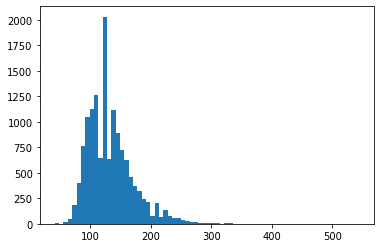

In [12]:
plt.hist([elem.shape[0] for elem in X_train], bins=70)

In [12]:
a_df.name.values[3569]

'f47834a8b6f7d08e7001a5b98f1e3867'

/home/makuhich/.local/lib/python3.9/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/makuhich/.local/lib/python3.9/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


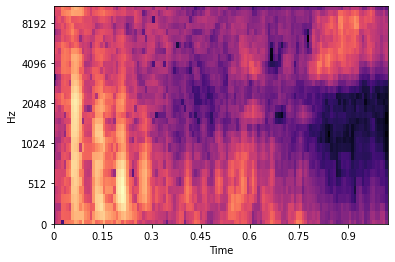

In [13]:
spec_plot(X_train[3569][:32,:], step=128)

In [21]:
model = keras.Sequential([
    keras.layers.Masking(mask_value=1, input_shape=(None, n_feat)),
    keras.layers.LSTM(64, activation='tanh', return_sequences=True),
    #keras.layers.TimeDistributed(keras.layers.Dense(128, activation='sigmoid')),
    keras.layers.TimeDistributed(keras.layers.Dense(1, activation='sigmoid')),
    keras.layers.GlobalAveragePooling1D()
])

In [22]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [23]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          49408     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           65        
_________________________________________________________________
global_average_pooling1d (Gl (None, 1)                 0         
Total params: 49,473
Trainable params: 49,473
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(x=X_train, y=a_df.target.values, epochs=6)

ValueError: Data cardinality is ambiguous:
  x sizes: 124, 124, 139, 98, 102, 147, 121, 87, 91, 83, 109, 124, 154, 139, 128, 188, 154, 94, 98, 102, 181, 173, 132, 147, 132, 136, 177, 121, 162, 79, 121, 87, 177, 136, 109, 121, 102, 113, 121, 147, 132, 106, 87, 91, 121, 113, 158, 94, 98, 102, 94, 117, 121, 244, 98, 109, 87, 106, 196, 87, 151, 91, 162, 154, 76, 169, 113, 136, 91, 196, 106, 203, 143, 109, 196, 147, 117, 147, 132, 94, 76, 102, 124, 162, 147, 139, 121, 158, 162, 79, 124, 113, 147, 94, 136, 121, 124, 147, 121, 181, 139, 121, 106, 121, 106, 121, 113, 117, 124, 132, 94, 248, 181, 139, 98, 173, 94, 196, 154, 158, 199, 169, 154, 162, 192, 132, 102, 136, 83, 143, 184, 83, 151, 147, 166, 181, 117, 136, 151, 128, 109, 128, 124, 102, 173, 128, 106, 132, 166, 94, 162, 132, 121, 158, 151, 106, 121, 117, 132, 117, 132, 98, 98, 98, 106, 91, 91, 124, 124, 94, 117, 196, 72, 169, 106, 158, 94, 136, 139, 143, 136, 124, 192, 98, 117, 241, 121, 199, 106, 139, 91, 124, 203, 132, 162, 139, 121, 98, 94, 136, 271, 83, 139, 147, 124, 98, 132, 199, 158, 124, 128, 229, 121, 199, 102, 109, 117, 132, 136, 136, 158, 109, 106, 214, 117, 124, 113, 76, 109, 106, 117, 173, 139, 128, 143, 87, 98, 113, 83, 139, 124, 132, 121, 102, 94, 158, 143, 136, 132, 87, 151, 117, 147, 162, 158, 128, 169, 143, 158, 173, 143, 91, 109, 91, 192, 139, 117, 173, 83, 132, 113, 139, 188, 222, 117, 94, 151, 143, 147, 162, 98, 91, 143, 154, 166, 117, 184, 121, 98, 98, 207, 121, 139, 196, 192, 87, 158, 94, 237, 94, 218, 158, 87, 233, 98, 124, 79, 94, 199, 154, 121, 143, 132, 117, 158, 113, 83, 166, 87, 132, 162, 263, 151, 87, 166, 166, 192, 121, 87, 158, 192, 237, 91, 124, 124, 132, 147, 117, 109, 106, 124, 132, 102, 136, 124, 143, 98, 91, 113, 136, 94, 147, 132, 151, 106, 143, 124, 136, 151, 121, 124, 121, 143, 106, 83, 102, 169, 128, 151, 136, 98, 136, 94, 162, 147, 218, 106, 132, 121, 241, 128, 98, 147, 222, 113, 169, 117, 162, 128, 91, 102, 113, 158, 113, 214, 132, 143, 121, 158, 106, 106, 158, 113, 98, 192, 94, 154, 117, 94, 124, 124, 124, 181, 98, 162, 143, 147, 79, 91, 121, 488, 136, 128, 132, 94, 113, 121, 109, 87, 162, 151, 117, 128, 83, 132, 173, 83, 256, 139, 94, 117, 139, 188, 113, 154, 121, 173, 83, 181, 83, 121, 192, 181, 184, 121, 184, 207, 173, 87, 132, 124, 98, 151, 154, 188, 132, 113, 102, 109, 132, 162, 226, 102, 147, 169, 113, 128, 102, 143, 128, 166, 76, 121, 117, 113, 94, 169, 162, 128, 162, 87, 109, 139, 121, 124, 203, 136, 222, 158, 151, 102, 154, 199, 192, 98, 147, 102, 124, 154, 158, 124, 158, 102, 154, 132, 166, 87, 91, 139, 211, 87, 121, 151, 121, 91, 109, 143, 244, 117, 147, 117, 203, 188, 98, 136, 158, 109, 94, 79, 154, 106, 128, 132, 188, 139, 98, 169, 87, 214, 151, 109, 102, 139, 154, 166, 117, 139, 91, 109, 109, 106, 154, 169, 83, 139, 109, 106, 158, 94, 87, 91, 143, 124, 222, 136, 113, 94, 121, 106, 267, 94, 143, 158, 136, 132, 121, 113, 136, 139, 151, 136, 177, 147, 139, 203, 259, 102, 98, 106, 147, 151, 87, 181, 147, 192, 162, 98, 181, 199, 94, 102, 109, 106, 117, 154, 158, 139, 177, 76, 136, 259, 162, 106, 98, 154, 106, 158, 113, 132, 162, 121, 184, 181, 121, 151, 72, 124, 151, 139, 117, 113, 128, 139, 79, 139, 181, 177, 87, 94, 177, 109, 102, 83, 113, 132, 181, 117, 91, 143, 132, 94, 124, 87, 136, 143, 124, 83, 136, 184, 124, 136, 128, 106, 94, 98, 151, 109, 233, 109, 162, 128, 147, 128, 139, 136, 132, 98, 151, 106, 79, 143, 136, 94, 76, 94, 128, 158, 94, 91, 124, 136, 136, 91, 98, 106, 117, 121, 94, 128, 218, 128, 117, 184, 136, 79, 79, 117, 128, 211, 98, 136, 91, 181, 184, 136, 121, 121, 132, 169, 121, 91, 87, 91, 117, 102, 106, 128, 83, 162, 94, 106, 158, 72, 154, 121, 147, 169, 83, 109, 72, 87, 98, 143, 124, 121, 106, 128, 79, 143, 124, 83, 147, 173, 121, 203, 87, 113, 83, 139, 136, 94, 109, 91, 229, 102, 106, 121, 117, 181, 117, 143, 139, 106, 113, 124, 139, 241, 237, 98, 117, 188, 417, 136, 166, 136, 147, 87, 87, 98, 83, 98, 87, 169, 192, 109, 102, 113, 143, 121, 117, 109, 158, 132, 109, 91, 117, 98, 117, 109, 211, 177, 109, 106, 188, 76, 121, 87, 132, 143, 173, 124, 102, 203, 106, 192, 113, 117, 136, 136, 151, 143, 166, 109, 158, 117, 312, 151, 83, 83, 139, 121, 128, 106, 102, 143, 132, 102, 143, 117, 113, 158, 166, 94, 124, 143, 102, 83, 91, 91, 121, 76, 124, 143, 139, 102, 91, 132, 136, 113, 109, 117, 94, 166, 102, 199, 199, 226, 132, 94, 102, 151, 124, 91, 139, 98, 139, 117, 79, 109, 158, 158, 102, 79, 199, 162, 106, 233, 113, 94, 109, 109, 128, 124, 136, 106, 106, 139, 117, 109, 184, 124, 124, 128, 76, 132, 158, 121, 173, 98, 124, 136, 132, 132, 121, 158, 113, 218, 132, 106, 158, 124, 106, 117, 162, 113, 136, 147, 132, 121, 124, 143, 132, 162, 162, 98, 139, 166, 154, 87, 166, 139, 184, 113, 106, 128, 87, 72, 158, 109, 113, 98, 207, 109, 139, 173, 252, 128, 132, 128, 211, 136, 143, 143, 102, 79, 181, 162, 143, 147, 154, 79, 169, 117, 72, 91, 136, 124, 237, 124, 91, 121, 162, 196, 91, 199, 83, 162, 106, 117, 181, 139, 128, 132, 162, 136, 117, 121, 102, 184, 124, 113, 158, 222, 139, 124, 94, 102, 121, 117, 151, 91, 109, 136, 162, 207, 106, 151, 117, 147, 91, 117, 154, 184, 106, 162, 76, 124, 132, 83, 147, 158, 143, 132, 136, 91, 83, 147, 136, 117, 139, 98, 91, 98, 166, 106, 196, 132, 102, 154, 218, 121, 154, 124, 139, 109, 109, 169, 132, 124, 87, 173, 166, 181, 102, 91, 211, 132, 72, 113, 132, 79, 121, 128, 226, 91, 121, 169, 177, 124, 124, 173, 98, 113, 196, 124, 181, 147, 102, 181, 136, 91, 192, 177, 154, 98, 79, 109, 109, 166, 117, 124, 117, 169, 128, 158, 113, 87, 166, 124, 124, 98, 128, 109, 136, 117, 124, 91, 211, 128, 94, 139, 117, 147, 72, 132, 128, 121, 154, 106, 121, 121, 124, 113, 98, 91, 203, 173, 151, 109, 162, 79, 128, 124, 128, 158, 151, 132, 124, 132, 147, 154, 106, 196, 128, 154, 143, 139, 184, 151, 121, 226, 98, 128, 98, 147, 154, 83, 113, 188, 139, 173, 132, 87, 102, 147, 203, 83, 136, 124, 128, 166, 177, 113, 132, 117, 132, 136, 151, 136, 94, 124, 181, 128, 139, 117, 124, 188, 117, 117, 109, 79, 203, 188, 124, 121, 87, 128, 151, 109, 203, 102, 109, 94, 151, 147, 128, 128, 184, 154, 181, 334, 136, 128, 128, 98, 94, 94, 199, 117, 136, 98, 94, 121, 124, 162, 121, 136, 94, 128, 102, 143, 68, 136, 102, 117, 158, 113, 166, 94, 83, 94, 94, 117, 147, 244, 143, 109, 158, 169, 102, 76, 184, 91, 143, 139, 106, 192, 109, 124, 102, 162, 132, 64, 91, 106, 162, 136, 76, 143, 124, 203, 166, 154, 151, 139, 241, 98, 117, 177, 173, 98, 124, 147, 143, 132, 109, 98, 102, 166, 211, 188, 83, 128, 199, 94, 106, 147, 87, 128, 136, 117, 117, 109, 117, 169, 139, 192, 136, 128, 91, 151, 128, 102, 98, 87, 91, 79, 113, 94, 121, 83, 117, 117, 169, 87, 162, 128, 113, 102, 233, 83, 136, 162, 87, 166, 121, 128, 109, 136, 173, 158, 113, 106, 102, 117, 117, 143, 121, 102, 162, 128, 94, 94, 147, 117, 139, 181, 117, 121, 169, 113, 106, 154, 222, 252, 128, 154, 188, 117, 147, 106, 113, 177, 102, 98, 226, 121, 113, 154, 98, 102, 136, 143, 173, 132, 147, 121, 113, 166, 83, 98, 139, 128, 106, 226, 121, 121, 106, 214, 132, 106, 132, 151, 83, 102, 121, 124, 151, 117, 154, 177, 139, 72, 192, 128, 158, 177, 151, 91, 124, 151, 109, 147, 124, 113, 121, 117, 102, 102, 218, 113, 222, 91, 113, 87, 91, 147, 139, 143, 128, 136, 139, 106, 226, 117, 109, 121, 106, 139, 121, 106, 139, 136, 98, 151, 154, 188, 83, 132, 136, 121, 158, 136, 229, 136, 106, 98, 113, 169, 102, 98, 106, 181, 147, 91, 166, 98, 207, 102, 158, 139, 173, 102, 124, 117, 121, 87, 132, 121, 113, 91, 72, 124, 117, 109, 136, 169, 94, 102, 158, 237, 124, 132, 117, 154, 151, 143, 87, 94, 106, 173, 169, 331, 226, 192, 117, 139, 286, 87, 154, 132, 128, 207, 136, 113, 143, 61, 143, 106, 143, 181, 83, 102, 259, 94, 106, 184, 154, 113, 147, 98, 143, 218, 91, 233, 139, 154, 128, 199, 128, 233, 139, 192, 139, 109, 87, 181, 87, 162, 147, 102, 98, 113, 91, 154, 109, 139, 124, 79, 94, 158, 79, 79, 136, 143, 128, 87, 91, 136, 83, 113, 158, 241, 162, 98, 98, 79, 98, 211, 177, 139, 162, 113, 121, 91, 128, 181, 169, 132, 83, 83, 109, 72, 113, 79, 196, 162, 199, 136, 98, 117, 136, 199, 121, 109, 203, 83, 188, 121, 94, 207, 132, 91, 158, 154, 203, 102, 106, 124, 128, 64, 94, 207, 147, 109, 98, 106, 98, 139, 117, 158, 124, 106, 143, 158, 128, 154, 158, 139, 132, 121, 169, 199, 143, 91, 94, 143, 109, 154, 106, 106, 226, 151, 211, 207, 139, 192, 87, 169, 173, 124, 139, 143, 151, 124, 117, 139, 113, 109, 109, 98, 124, 128, 106, 158, 109, 173, 109, 244, 91, 124, 218, 132, 136, 158, 132, 98, 139, 143, 132, 79, 237, 139, 158, 117, 188, 158, 98, 154, 132, 117, 128, 121, 91, 214, 169, 162, 143, 143, 166, 237, 139, 136, 132, 117, 83, 87, 121, 121, 109, 113, 177, 169, 79, 124, 139, 173, 169, 61, 113, 124, 154, 94, 192, 109, 158, 106, 132, 147, 91, 94, 91, 199, 113, 124, 162, 106, 124, 121, 256, 91, 143, 94, 139, 109, 128, 121, 173, 237, 121, 139, 169, 106, 109, 147, 87, 154, 109, 79, 124, 128, 162, 147, 199, 196, 132, 151, 117, 136, 91, 102, 98, 132, 169, 98, 87, 102, 151, 192, 147, 218, 158, 117, 147, 147, 151, 124, 196, 184, 162, 91, 98, 181, 143, 109, 94, 102, 143, 91, 151, 143, 106, 233, 94, 87, 244, 94, 162, 162, 214, 98, 94, 169, 128, 177, 132, 106, 91, 188, 136, 98, 199, 139, 136, 109, 132, 94, 113, 87, 199, 181, 136, 117, 132, 83, 117, 132, 117, 117, 158, 154, 91, 158, 94, 132, 233, 192, 91, 102, 121, 181, 121, 113, 121, 87, 98, 128, 169, 218, 49, 222, 211, 147, 188, 139, 94, 154, 98, 199, 136, 79, 102, 136, 136, 132, 128, 109, 113, 109, 169, 76, 128, 158, 117, 124, 76, 132, 109, 109, 121, 102, 199, 117, 117, 124, 143, 98, 158, 87, 184, 158, 106, 87, 117, 132, 136, 128, 98, 113, 154, 128, 128, 94, 132, 102, 121, 124, 132, 184, 76, 68, 121, 158, 158, 139, 218, 166, 158, 102, 136, 106, 98, 151, 136, 87, 91, 121, 229, 98, 214, 132, 91, 143, 132, 106, 79, 147, 121, 94, 143, 173, 154, 102, 188, 132, 151, 113, 113, 98, 124, 147, 181, 128, 87, 124, 147, 158, 132, 147, 113, 203, 166, 128, 136, 139, 109, 124, 83, 91, 139, 207, 106, 113, 162, 139, 136, 102, 151, 151, 102, 222, 79, 106, 117, 136, 109, 106, 166, 79, 106, 226, 83, 113, 91, 113, 117, 192, 109, 61, 166, 109, 91, 132, 192, 169, 136, 109, 98, 151, 211, 147, 139, 94, 102, 173, 76, 102, 98, 98, 147, 117, 113, 151, 87, 91, 109, 109, 106, 124, 87, 113, 109, 136, 151, 98, 143, 98, 113, 102, 79, 147, 113, 173, 98, 113, 106, 158, 106, 87, 113, 117, 184, 124, 109, 147, 109, 199, 94, 98, 139, 102, 121, 162, 106, 113, 106, 207, 117, 162, 147, 117, 237, 87, 177, 87, 94, 147, 139, 162, 196, 199, 173, 91, 106, 113, 136, 91, 162, 139, 143, 83, 121, 113, 143, 124, 121, 132, 121, 143, 147, 207, 98, 132, 117, 109, 121, 139, 136, 143, 143, 117, 72, 154, 128, 124, 211, 211, 113, 143, 143, 166, 98, 132, 128, 102, 87, 102, 162, 98, 162, 222, 106, 151, 132, 166, 106, 169, 154, 196, 91, 139, 166, 154, 162, 184, 143, 173, 154, 162, 158, 102, 196, 102, 91, 124, 98, 147, 154, 147, 323, 102, 218, 211, 113, 98, 147, 154, 102, 117, 169, 98, 147, 68, 64, 87, 98, 94, 136, 102, 143, 117, 109, 136, 241, 128, 132, 121, 143, 117, 106, 241, 226, 181, 117, 139, 113, 132, 91, 117, 132, 124, 68, 139, 139, 94, 139, 203, 143, 102, 132, 143, 87, 207, 139, 128, 109, 166, 124, 109, 158, 98, 147, 98, 211, 132, 181, 124, 226, 132, 143, 154, 136, 136, 214, 109, 196, 87, 94, 154, 184, 143, 109, 72, 147, 117, 154, 91, 136, 162, 94, 113, 128, 113, 162, 87, 83, 139, 106, 147, 124, 98, 98, 68, 121, 109, 79, 143, 102, 184, 109, 106, 139, 177, 192, 151, 132, 128, 106, 102, 87, 128, 109, 98, 106, 128, 128, 169, 124, 151, 124, 162, 121, 124, 139, 113, 113, 136, 188, 259, 211, 113, 102, 166, 94, 132, 139, 132, 151, 124, 113, 128, 173, 143, 117, 143, 173, 124, 177, 113, 158, 203, 109, 173, 143, 124, 128, 136, 121, 128, 121, 87, 117, 128, 143, 109, 102, 64, 192, 184, 98, 151, 166, 121, 87, 121, 91, 181, 106, 117, 222, 139, 113, 233, 106, 109, 109, 98, 207, 222, 121, 121, 83, 87, 147, 139, 136, 128, 83, 106, 154, 214, 121, 109, 199, 147, 109, 196, 102, 177, 106, 128, 136, 136, 79, 83, 151, 188, 136, 87, 158, 151, 94, 124, 147, 109, 109, 121, 132, 162, 128, 106, 199, 121, 113, 98, 113, 109, 169, 121, 102, 83, 143, 147, 139, 91, 113, 259, 139, 113, 132, 158, 121, 151, 128, 124, 124, 121, 151, 117, 91, 147, 166, 117, 128, 113, 94, 177, 98, 226, 147, 91, 139, 158, 98, 121, 117, 154, 121, 203, 128, 184, 106, 102, 102, 124, 158, 139, 244, 132, 98, 154, 173, 132, 128, 151, 139, 102, 136, 132, 109, 136, 121, 109, 113, 117, 91, 121, 94, 102, 169, 106, 91, 139, 106, 87, 181, 151, 87, 113, 117, 121, 117, 87, 124, 91, 102, 124, 136, 154, 76, 121, 181, 188, 87, 106, 192, 98, 132, 91, 136, 79, 124, 218, 136, 136, 241, 151, 151, 139, 98, 106, 162, 136, 68, 139, 136, 109, 136, 79, 117, 166, 196, 211, 124, 154, 143, 184, 203, 154, 128, 113, 106, 136, 181, 128, 91, 102, 132, 147, 158, 91, 121, 76, 128, 132, 151, 113, 102, 147, 121, 91, 124, 128, 199, 117, 72, 87, 113, 199, 203, 132, 181, 143, 109, 136, 79, 128, 199, 151, 91, 136, 94, 151, 124, 143, 121, 76, 83, 199, 211, 121, 117, 106, 151, 136, 113, 94, 109, 218, 121, 151, 128, 128, 132, 151, 94, 113, 181, 128, 136, 136, 128, 128, 98, 181, 124, 102, 154, 98, 124, 121, 226, 91, 121, 91, 158, 177, 192, 136, 121, 106, 222, 121, 91, 124, 158, 87, 79, 177, 98, 124, 166, 117, 94, 106, 98, 136, 91, 136, 158, 117, 154, 132, 132, 151, 181, 117, 158, 113, 91, 218, 121, 124, 147, 128, 124, 128, 169, 136, 192, 139, 132, 136, 139, 151, 124, 121, 109, 222, 113, 147, 196, 128, 124, 147, 143, 106, 169, 199, 91, 106, 132, 143, 169, 139, 128, 128, 173, 121, 113, 106, 177, 143, 154, 117, 113, 113, 173, 76, 124, 166, 124, 94, 151, 492, 147, 102, 102, 98, 218, 143, 132, 109, 117, 121, 102, 136, 154, 124, 94, 143, 154, 113, 136, 143, 113, 139, 117, 117, 79, 109, 106, 117, 57, 109, 113, 117, 139, 132, 184, 83, 106, 139, 121, 94, 132, 121, 226, 121, 136, 136, 113, 181, 177, 106, 136, 136, 166, 121, 91, 113, 117, 177, 207, 132, 162, 143, 109, 91, 121, 128, 147, 154, 83, 241, 132, 169, 169, 87, 128, 128, 181, 109, 286, 214, 124, 132, 106, 162, 102, 162, 244, 98, 132, 169, 184, 188, 49, 132, 72, 79, 162, 154, 192, 124, 94, 147, 98, 128, 109, 151, 151, 124, 218, 106, 229, 94, 113, 151, 151, 151, 162, 106, 83, 136, 98, 162, 94, 102, 87, 139, 83, 109, 154, 79, 162, 124, 98, 169, 124, 312, 196, 128, 102, 196, 117, 169, 102, 98, 94, 87, 121, 151, 147, 102, 151, 128, 143, 207, 151, 87, 136, 109, 289, 128, 154, 109, 113, 117, 136, 98, 98, 147, 154, 136, 139, 154, 106, 83, 162, 83, 121, 128, 162, 128, 117, 121, 76, 117, 102, 139, 94, 128, 109, 181, 113, 128, 169, 147, 117, 109, 136, 106, 162, 98, 94, 83, 143, 218, 109, 83, 226, 91, 263, 128, 91, 289, 147, 162, 121, 94, 188, 124, 188, 151, 109, 158, 136, 274, 177, 106, 98, 128, 128, 98, 94, 109, 169, 196, 136, 376, 117, 109, 181, 106, 124, 102, 79, 98, 139, 102, 177, 132, 139, 173, 87, 151, 109, 154, 102, 113, 113, 102, 196, 229, 79, 106, 136, 136, 124, 218, 143, 79, 121, 109, 139, 154, 132, 106, 113, 113, 207, 83, 121, 124, 124, 113, 124, 166, 124, 91, 117, 147, 312, 109, 98, 147, 196, 102, 113, 117, 76, 113, 143, 109, 91, 87, 128, 106, 124, 211, 143, 121, 117, 124, 76, 154, 117, 109, 68, 169, 124, 128, 143, 184, 136, 147, 147, 121, 151, 98, 128, 136, 184, 173, 106, 98, 87, 79, 132, 154, 147, 124, 136, 98, 132, 91, 196, 181, 109, 113, 136, 136, 128, 94, 222, 158, 136, 94, 102, 181, 117, 113, 132, 124, 136, 102, 222, 151, 158, 136, 94, 151, 128, 136, 124, 109, 83, 162, 83, 147, 151, 128, 98, 94, 91, 109, 169, 102, 128, 196, 121, 106, 154, 98, 124, 188, 124, 91, 203, 177, 113, 102, 143, 94, 106, 117, 106, 132, 143, 154, 136, 109, 121, 188, 143, 121, 124, 181, 154, 147, 158, 233, 102, 132, 117, 169, 132, 98, 102, 121, 124, 166, 162, 68, 128, 68, 173, 139, 121, 106, 162, 143, 121, 117, 124, 151, 233, 139, 128, 121, 139, 91, 124, 154, 188, 94, 106, 121, 237, 91, 109, 98, 79, 226, 139, 72, 214, 199, 121, 132, 98, 188, 124, 121, 117, 151, 143, 106, 196, 109, 136, 117, 173, 87, 109, 207, 124, 113, 98, 121, 158, 128, 117, 188, 147, 211, 143, 124, 132, 128, 169, 98, 91, 121, 109, 98, 139, 192, 188, 124, 132, 91, 124, 102, 124, 132, 207, 91, 143, 136, 98, 192, 91, 136, 169, 136, 233, 64, 113, 147, 121, 124, 79, 214, 94, 113, 109, 117, 76, 132, 124, 181, 154, 139, 124, 121, 121, 91, 117, 192, 136, 158, 109, 121, 113, 158, 109, 91, 128, 184, 91, 203, 143, 117, 68, 121, 83, 83, 162, 199, 109, 121, 173, 229, 274, 121, 83, 106, 109, 147, 199, 121, 139, 229, 169, 132, 94, 196, 113, 211, 117, 94, 113, 113, 143, 143, 124, 128, 121, 199, 128, 132, 109, 139, 113, 121, 109, 83, 158, 87, 136, 109, 218, 199, 229, 132, 169, 98, 109, 121, 177, 128, 166, 203, 169, 139, 98, 98, 79, 98, 166, 139, 98, 106, 109, 188, 169, 98, 151, 113, 184, 124, 139, 139, 136, 158, 94, 121, 94, 181, 113, 121, 102, 102, 139, 91, 143, 113, 151, 143, 102, 121, 98, 128, 203, 147, 121, 102, 83, 98, 188, 181, 106, 128, 139, 139, 117, 166, 117, 94, 226, 61, 121, 169, 94, 94, 98, 136, 124, 158, 139, 102, 139, 162, 143, 124, 162, 173, 173, 162, 113, 68, 199, 102, 121, 121, 109, 143, 128, 173, 72, 147, 147, 143, 87, 226, 117, 271, 162, 121, 207, 147, 151, 124, 154, 259, 87, 147, 124, 132, 106, 147, 113, 121, 132, 207, 154, 128, 181, 102, 132, 136, 211, 177, 113, 113, 128, 102, 147, 102, 132, 109, 136, 188, 151, 113, 158, 154, 98, 102, 158, 124, 267, 72, 98, 109, 166, 151, 94, 177, 76, 102, 109, 166, 154, 132, 173, 154, 98, 151, 151, 136, 109, 158, 151, 117, 113, 102, 102, 173, 109, 124, 169, 113, 166, 106, 109, 158, 42, 124, 166, 124, 222, 128, 151, 143, 162, 139, 106, 143, 139, 151, 106, 151, 106, 188, 109, 94, 132, 128, 113, 113, 113, 181, 128, 128, 102, 136, 102, 177, 128, 132, 91, 226, 222, 113, 124, 192, 136, 162, 109, 151, 113, 132, 139, 147, 132, 117, 132, 106, 139, 188, 226, 117, 94, 106, 136, 226, 113, 102, 117, 166, 162, 98, 121, 124, 113, 147, 94, 128, 117, 79, 94, 136, 87, 143, 102, 102, 143, 132, 102, 162, 117, 109, 136, 188, 113, 151, 98, 113, 132, 128, 154, 136, 102, 147, 109, 154, 218, 94, 98, 222, 218, 136, 143, 91, 184, 162, 87, 143, 136, 113, 106, 79, 241, 106, 136, 124, 173, 154, 106, 173, 166, 98, 158, 98, 98, 102, 117, 139, 113, 166, 102, 113, 124, 128, 143, 166, 136, 121, 154, 109, 158, 117, 151, 109, 102, 106, 181, 109, 286, 136, 94, 98, 109, 199, 117, 109, 121, 121, 169, 143, 68, 106, 177, 98, 128, 94, 102, 154, 199, 124, 109, 121, 214, 91, 121, 151, 113, 162, 102, 91, 184, 106, 109, 102, 169, 124, 147, 102, 166, 181, 121, 151, 121, 83, 121, 113, 136, 158, 132, 117, 132, 222, 147, 128, 211, 143, 158, 136, 158, 139, 121, 166, 91, 109, 124, 117, 113, 139, 109, 94, 151, 109, 136, 79, 91, 94, 117, 132, 117, 184, 106, 136, 162, 109, 98, 177, 79, 211, 98, 124, 169, 113, 113, 188, 124, 98, 139, 106, 106, 139, 139, 106, 233, 106, 128, 188, 124, 87, 94, 87, 263, 109, 113, 117, 207, 136, 113, 106, 128, 106, 383, 87, 132, 143, 121, 162, 94, 263, 121, 87, 94, 136, 106, 136, 87, 109, 121, 124, 139, 196, 102, 61, 203, 117, 132, 147, 143, 252, 139, 139, 222, 166, 218, 102, 94, 98, 124, 139, 98, 166, 248, 76, 113, 98, 143, 139, 143, 181, 94, 132, 237, 173, 151, 124, 199, 158, 117, 94, 106, 248, 158, 124, 106, 98, 98, 94, 136, 154, 117, 139, 136, 199, 121, 109, 87, 124, 117, 128, 102, 139, 136, 102, 98, 102, 102, 143, 121, 139, 136, 124, 136, 169, 199, 83, 87, 94, 102, 117, 121, 226, 252, 98, 196, 106, 94, 106, 139, 98, 124, 124, 91, 128, 158, 196, 158, 154, 136, 173, 102, 218, 113, 91, 139, 173, 109, 76, 173, 94, 143, 83, 184, 79, 151, 113, 117, 143, 113, 143, 76, 94, 196, 91, 102, 147, 177, 87, 102, 91, 128, 188, 87, 132, 169, 124, 98, 102, 79, 109, 76, 188, 158, 124, 139, 94, 162, 91, 94, 132, 177, 128, 151, 121, 147, 158, 151, 147, 102, 98, 94, 132, 147, 151, 98, 136, 106, 102, 83, 196, 158, 121, 132, 151, 132, 151, 154, 79, 158, 199, 128, 143, 169, 166, 147, 132, 117, 132, 173, 128, 83, 147, 158, 87, 158, 87, 113, 121, 143, 211, 226, 102, 282, 91, 94, 162, 177, 196, 162, 117, 106, 117, 143, 94, 147, 158, 102, 113, 98, 188, 192, 117, 102, 124, 121, 244, 109, 169, 196, 94, 128, 124, 102, 166, 121, 139, 124, 132, 147, 79, 98, 199, 113, 162, 109, 87, 102, 136, 113, 76, 106, 117, 117, 218, 121, 143, 139, 91, 132, 113, 113, 222, 102, 151, 113, 94, 207, 94, 226, 128, 113, 136, 132, 181, 94, 151, 121, 117, 121, 121, 128, 136, 109, 158, 109, 94, 124, 113, 154, 181, 154, 203, 117, 244, 139, 87, 124, 226, 139, 139, 124, 143, 132, 143, 109, 121, 162, 124, 121, 124, 102, 124, 173, 102, 147, 151, 79, 109, 214, 109, 139, 158, 158, 136, 121, 79, 102, 121, 162, 143, 106, 192, 132, 102, 83, 124, 128, 128, 136, 109, 222, 143, 147, 139, 211, 124, 124, 121, 132, 121, 151, 102, 143, 121, 76, 102, 128, 154, 188, 121, 177, 143, 124, 121, 98, 271, 139, 181, 113, 117, 132, 151, 143, 83, 128, 166, 117, 147, 151, 151, 128, 117, 124, 113, 117, 158, 124, 91, 87, 102, 184, 143, 87, 117, 143, 98, 98, 113, 136, 76, 132, 139, 214, 169, 147, 214, 117, 196, 91, 113, 98, 113, 98, 132, 143, 102, 94, 98, 98, 162, 154, 98, 136, 87, 147, 147, 132, 113, 214, 98, 124, 132, 98, 106, 196, 117, 106, 132, 117, 91, 94, 98, 79, 128, 83, 136, 222, 117, 109, 192, 61, 124, 256, 181, 121, 124, 162, 106, 124, 196, 162, 128, 166, 109, 117, 132, 128, 166, 102, 98, 128, 113, 158, 162, 147, 229, 83, 98, 222, 106, 106, 218, 139, 124, 113, 124, 184, 151, 109, 184, 109, 256, 109, 121, 79, 87, 181, 106, 87, 109, 83, 147, 128, 121, 102, 241, 124, 154, 117, 229, 124, 132, 173, 139, 181, 109, 173, 113, 121, 102, 128, 124, 124, 166, 83, 98, 162, 128, 94, 132, 196, 203, 106, 124, 98, 98, 136, 124, 106, 158, 181, 282, 207, 109, 158, 124, 196, 113, 121, 113, 154, 136, 132, 147, 124, 166, 124, 162, 124, 94, 154, 113, 222, 117, 139, 173, 132, 188, 121, 188, 61, 102, 151, 94, 94, 87, 244, 117, 113, 229, 181, 94, 117, 117, 211, 83, 136, 106, 121, 188, 136, 102, 102, 109, 124, 177, 139, 98, 72, 139, 121, 124, 121, 124, 87, 124, 124, 121, 128, 136, 117, 94, 117, 128, 169, 151, 109, 139, 166, 128, 136, 83, 94, 132, 139, 124, 184, 109, 139, 128, 94, 94, 143, 106, 72, 113, 106, 173, 154, 132, 162, 102, 147, 91, 124, 109, 143, 102, 83, 143, 109, 136, 128, 117, 207, 109, 106, 91, 166, 106, 102, 136, 151, 117, 98, 102, 117, 98, 87, 91, 117, 87, 162, 91, 124, 121, 98, 91, 124, 72, 132, 327, 143, 181, 98, 109, 132, 98, 154, 154, 203, 83, 169, 154, 154, 136, 113, 151, 121, 132, 113, 94, 128, 154, 143, 106, 83, 151, 151, 102, 151, 79, 113, 139, 91, 117, 177, 154, 117, 211, 188, 113, 151, 102, 136, 106, 158, 136, 113, 117, 109, 222, 143, 151, 203, 83, 94, 94, 177, 121, 121, 173, 124, 136, 121, 143, 124, 132, 147, 136, 117, 229, 117, 158, 117, 76, 188, 87, 113, 121, 128, 113, 102, 121, 109, 173, 109, 226, 136, 147, 139, 263, 124, 124, 196, 143, 124, 192, 98, 109, 162, 132, 139, 113, 136, 102, 121, 106, 132, 154, 121, 143, 124, 121, 98, 151, 91, 109, 166, 106, 94, 158, 147, 132, 106, 106, 87, 184, 192, 143, 188, 124, 124, 91, 91, 192, 173, 196, 151, 94, 117, 117, 102, 117, 181, 121, 124, 327, 192, 98, 158, 98, 106, 109, 147, 136, 83, 102, 136, 128, 169, 139, 106, 102, 91, 136, 117, 98, 181, 199, 139, 132, 158, 117, 162, 136, 169, 117, 132, 87, 184, 113, 91, 117, 72, 83, 192, 154, 117, 169, 117, 121, 132, 177, 166, 124, 106, 229, 158, 102, 158, 139, 158, 132, 121, 143, 94, 128, 158, 151, 132, 214, 143, 154, 222, 192, 139, 102, 139, 162, 102, 136, 124, 214, 166, 109, 113, 94, 109, 184, 136, 166, 117, 91, 91, 207, 94, 151, 169, 109, 177, 166, 132, 102, 151, 151, 166, 308, 184, 139, 117, 128, 162, 109, 124, 151, 109, 136, 128, 94, 132, 143, 158, 87, 91, 106, 162, 136, 102, 162, 139, 128, 106, 94, 124, 136, 98, 117, 113, 94, 158, 162, 166, 109, 136, 177, 214, 169, 94, 132, 173, 91, 143, 106, 166, 132, 121, 154, 72, 91, 147, 113, 181, 192, 139, 214, 199, 102, 61, 87, 162, 124, 113, 91, 143, 139, 106, 196, 162, 162, 109, 151, 79, 128, 136, 143, 151, 68, 136, 169, 128, 98, 102, 166, 173, 117, 132, 109, 94, 192, 147, 132, 154, 177, 98, 91, 218, 226, 91, 106, 158, 143, 211, 226, 83, 79, 162, 98, 214, 192, 124, 196, 124, 121, 229, 91, 147, 87, 151, 91, 132, 79, 274, 113, 132, 113, 162, 124, 132, 147, 132, 128, 147, 109, 166, 91, 98, 151, 177, 83, 121, 106, 136, 128, 199, 98, 87, 121, 98, 83, 169, 211, 136, 132, 121, 79, 132, 121, 121, 113, 113, 143, 151, 98, 98, 94, 166, 106, 91, 136, 109, 132, 199, 166, 143, 158, 188, 124, 121, 124, 136, 117, 177, 128, 128, 132, 143, 117, 184, 94, 222, 147, 128, 94, 109, 139, 139, 143, 169, 154, 121, 124, 177, 117, 154, 147, 121, 94, 158, 94, 109, 248, 109, 106, 136, 94, 226, 72, 113, 214, 113, 151, 91, 98, 94, 151, 151, 113, 124, 151, 106, 94, 117, 91, 121, 184, 113, 158, 124, 121, 87, 117, 113, 211, 117, 151, 121, 124, 136, 192, 158, 177, 109, 214, 139, 128, 87, 117, 128, 203, 132, 151, 106, 151, 184, 139, 98, 154, 139, 136, 166, 121, 181, 124, 87, 132, 188, 113, 196, 98, 207, 83, 169, 117, 106, 91, 151, 124, 151, 169, 117, 124, 147, 154, 117, 147, 98, 117, 147, 154, 121, 143, 106, 128, 143, 121, 181, 94, 132, 259, 128, 158, 132, 117, 91, 151, 94, 188, 147, 124, 121, 117, 98, 121, 214, 241, 124, 143, 158, 117, 124, 109, 177, 102, 121, 147, 132, 151, 132, 121, 91, 124, 184, 72, 207, 98, 162, 132, 132, 109, 132, 162, 109, 94, 87, 151, 214, 94, 83, 124, 151, 177, 94, 143, 143, 143, 128, 124, 139, 166, 139, 147, 128, 136, 128, 117, 136, 94, 94, 188, 117, 143, 91, 188, 151, 124, 143, 106, 124, 121, 76, 181, 98, 177, 121, 147, 113, 136, 109, 136, 87, 121, 154, 211, 124, 124, 98, 98, 109, 113, 87, 113, 117, 151, 72, 147, 132, 143, 237, 203, 173, 139, 136, 124, 121, 117, 147, 117, 128, 124, 143, 106, 181, 147, 128, 113, 128, 128, 143, 124, 132, 132, 136, 162, 124, 237, 139, 143, 106, 106, 98, 132, 83, 128, 143, 181, 136, 139, 136, 121, 274, 128, 121, 139, 87, 87, 136, 79, 199, 94, 102, 128, 102, 226, 102, 151, 109, 124, 158, 106, 91, 181, 132, 117, 139, 286, 166, 117, 76, 106, 124, 128, 196, 102, 102, 143, 128, 102, 203, 102, 128, 87, 91, 128, 139, 181, 124, 166, 106, 113, 102, 151, 158, 98, 271, 143, 106, 117, 94, 98, 252, 124, 113, 139, 139, 98, 106, 91, 162, 102, 113, 124, 177, 169, 91, 98, 132, 117, 151, 98, 106, 128, 128, 94, 124, 222, 177, 94, 147, 79, 94, 132, 151, 166, 136, 226, 184, 124, 102, 113, 121, 102, 188, 113, 147, 196, 139, 76, 109, 113, 91, 244, 139, 169, 106, 124, 248, 136, 143, 121, 113, 98, 106, 98, 154, 102, 106, 121, 113, 128, 121, 173, 113, 98, 128, 147, 248, 102, 154, 169, 121, 117, 184, 147, 132, 121, 181, 173, 102, 154, 117, 94, 139, 132, 94, 177, 98, 128, 128, 98, 98, 121, 158, 379, 121, 162, 162, 102, 98, 102, 184, 83, 109, 162, 158, 68, 143, 136, 151, 117, 158, 136, 87, 181, 192, 226, 136, 117, 181, 181, 139, 94, 136, 136, 91, 87, 83, 136, 154, 109, 109, 196, 106, 158, 98, 91, 102, 113, 102, 128, 117, 158, 109, 113, 132, 128, 121, 91, 136, 64, 181, 124, 128, 128, 136, 117, 162, 128, 132, 301, 109, 79, 117, 109, 113, 162, 117, 139, 83, 121, 124, 94, 117, 121, 121, 169, 113, 98, 151, 128, 87, 113, 263, 113, 94, 132, 132, 109, 94, 173, 154, 226, 143, 109, 109, 128, 94, 72, 83, 102, 113, 274, 117, 121, 124, 98, 162, 184, 102, 124, 109, 106, 158, 132, 121, 169, 181, 117, 102, 173, 158, 121, 136, 139, 94, 102, 117, 106, 109, 132, 173, 91, 72, 128, 132, 109, 286, 102, 139, 117, 151, 106, 79, 154, 94, 102, 106, 121, 121, 162, 113, 143, 147, 226, 169, 117, 188, 106, 109, 106, 121, 98, 192, 181, 102, 124, 207, 91, 196, 151, 109, 136, 113, 121, 151, 151, 128, 109, 124, 177, 132, 147, 177, 113, 154, 83, 109, 94, 102, 72, 72, 128, 124, 143, 169, 196, 143, 113, 94, 98, 184, 139, 102, 147, 121, 124, 117, 143, 87, 124, 181, 139, 117, 83, 177, 139, 151, 121, 128, 121, 136, 128, 102, 94, 203, 98, 158, 139, 91, 121, 158, 222, 94, 147, 72, 109, 87, 158, 158, 94, 94, 136, 121, 64, 158, 79, 128, 188, 143, 143, 158, 79, 256, 113, 79, 184, 94, 136, 181, 109, 226, 76, 259, 83, 94, 94, 87, 143, 162, 211, 94, 98, 158, 113, 124, 106, 57, 79, 117, 151, 124, 173, 94, 177, 192, 113, 151, 94, 117, 109, 188, 169, 128, 147, 102, 184, 113, 91, 83, 113, 121, 94, 106, 109, 91, 132, 91, 79, 117, 211, 147, 109, 143, 162, 98, 188, 124, 98, 91, 132, 188, 117, 113, 151, 143, 72, 117, 102, 143, 177, 121, 98, 166, 124, 128, 132, 117, 109, 106, 154, 113, 124, 128, 113, 188, 94, 106, 203, 117, 113, 106, 98, 124, 106, 94, 143, 102, 136, 211, 64, 169, 132, 136, 151, 102, 94, 128, 151, 98, 139, 121, 154, 91, 166, 248, 196, 113, 109, 98, 147, 124, 113, 109, 181, 106, 109, 117, 188, 121, 117, 154, 166, 132, 136, 132, 76, 271, 136, 98, 121, 106, 124, 109, 162, 173, 124, 124, 117, 166, 181, 158, 214, 121, 113, 177, 147, 128, 94, 218, 91, 98, 139, 196, 128, 91, 139, 143, 169, 184, 162, 169, 151, 203, 106, 91, 162, 162, 113, 113, 136, 139, 106, 94, 83, 102, 252, 106, 109, 248, 169, 124, 87, 121, 76, 117, 109, 222, 72, 121, 117, 113, 94, 98, 166, 102, 98, 151, 79, 199, 128, 91, 98, 102, 109, 121, 121, 166, 83, 196, 102, 169, 79, 132, 117, 91, 151, 136, 109, 128, 128, 76, 147, 117, 87, 128, 132, 237, 113, 136, 147, 132, 226, 117, 83, 106, 121, 117, 98, 124, 91, 109, 177, 158, 196, 121, 132, 158, 177, 158, 128, 166, 199, 139, 121, 282, 113, 124, 124, 177, 91, 139, 94, 154, 158, 109, 143, 147, 117, 124, 143, 113, 188, 117, 117, 121, 293, 139, 124, 143, 79, 106, 109, 151, 143, 94, 113, 166, 106, 113, 79, 136, 117, 117, 177, 109, 113, 188, 139, 102, 147, 169, 128, 106, 173, 151, 143, 169, 102, 147, 109, 196, 132, 222, 94, 229, 124, 102, 98, 214, 136, 136, 132, 237, 158, 124, 196, 113, 143, 106, 177, 162, 177, 121, 162, 117, 113, 117, 132, 132, 211, 102, 117, 143, 87, 136, 113, 117, 136, 91, 72, 207, 169, 128, 117, 98, 87, 117, 139, 222, 61, 121, 304, 173, 121, 188, 181, 102, 121, 139, 196, 113, 91, 113, 173, 87, 136, 113, 124, 128, 181, 102, 132, 154, 207, 117, 147, 173, 151, 154, 218, 102, 132, 83, 229, 173, 91, 143, 113, 117, 124, 136, 83, 154, 91, 136, 79, 136, 109, 136, 98, 128, 177, 87, 121, 121, 147, 98, 128, 128, 192, 113, 147, 102, 132, 154, 113, 87, 117, 102, 154, 143, 203, 151, 207, 169, 173, 196, 94, 117, 158, 151, 109, 139, 102, 132, 218, 113, 102, 91, 128, 173, 143, 162, 136, 173, 252, 173, 158, 113, 72, 136, 113, 87, 128, 136, 94, 128, 147, 203, 128, 229, 139, 139, 124, 106, 132, 132, 117, 76, 199, 76, 147, 181, 113, 192, 79, 91, 259, 139, 72, 154, 136, 166, 162, 106, 136, 121, 102, 79, 102, 124, 181, 327, 102, 154, 124, 132, 106, 151, 121, 94, 158, 229, 158, 263, 132, 121, 169, 166, 184, 113, 94, 158, 211, 207, 124, 128, 248, 162, 169, 139, 109, 158, 128, 136, 147, 139, 72, 188, 132, 184, 173, 188, 128, 91, 132, 113, 139, 87, 94, 136, 147, 132, 109, 113, 181, 124, 42, 117, 181, 102, 102, 181, 102, 98, 98, 151, 143, 181, 139, 226, 76, 113, 154, 113, 117, 166, 143, 121, 229, 147, 91, 106, 229, 181, 166, 87, 192, 113, 113, 113, 94, 136, 128, 106, 147, 117, 229, 124, 102, 128, 106, 136, 106, 139, 87, 94, 109, 76, 106, 121, 83, 117, 124, 109, 143, 128, 136, 124, 136, 87, 214, 151, 188, 109, 128, 79, 124, 151, 136, 177, 98, 109, 102, 83, 106, 87, 226, 199, 53, 154, 158, 91, 166, 91, 117, 136, 106, 83, 106, 143, 113, 211, 158, 136, 147, 94, 132, 128, 132, 192, 117, 143, 124, 154, 132, 162, 98, 113, 117, 139, 113, 124, 184, 136, 166, 109, 121, 94, 128, 132, 102, 113, 117, 121, 64, 199, 117, 109, 147, 169, 87, 143, 181, 117, 124, 158, 124, 151, 113, 143, 113, 91, 166, 151, 109, 154, 136, 244, 124, 128, 211, 154, 113, 177, 177, 106, 113, 106, 128, 98, 139, 177, 124, 113, 173, 177, 233, 109, 229, 139, 121, 214, 158, 76, 233, 184, 128, 106, 151, 79, 83, 139, 117, 166, 124, 121, 169, 154, 143, 98, 143, 121, 162, 106, 121, 117, 124, 91, 128, 87, 139, 147, 87, 154, 109, 136, 139, 94, 169, 106, 154, 143, 87, 166, 196, 143, 117, 188, 109, 169, 87, 124, 113, 117, 136, 102, 117, 121, 121, 136, 106, 207, 109, 132, 87, 117, 139, 87, 87, 128, 124, 117, 132, 94, 102, 117, 132, 181, 143, 229, 124, 124, 117, 106, 124, 98, 132, 154, 158, 158, 162, 166, 128, 136, 173, 128, 154, 259, 139, 87, 124, 147, 109, 79, 166, 124, 94, 113, 128, 106, 68, 139, 109, 132, 169, 124, 102, 139, 124, 109, 124, 151, 106, 136, 154, 102, 151, 121, 147, 139, 132, 166, 121, 154, 98, 128, 109, 106, 139, 211, 98, 124, 207, 94, 154, 162, 147, 139, 188, 139, 143, 113, 188, 214, 181, 128, 177, 106, 102, 128, 222, 139, 87, 124, 113, 132, 229, 147, 113, 147, 121, 87, 196, 94, 151, 124, 207, 151, 94, 218, 91, 94, 154, 113, 147, 136, 166, 139, 218, 106, 121, 237, 109, 124, 136, 139, 128, 98, 109, 166, 154, 102, 109, 102, 162, 162, 158, 117, 244, 113, 158, 151, 147, 158, 83, 109, 177, 109, 124, 76, 94, 124, 132, 72, 72, 109, 102, 128, 169, 109, 169, 136, 196, 76, 98, 87, 87, 124, 113, 113, 91, 147, 109, 124, 102, 72, 188, 109, 121, 124, 158, 72, 166, 162, 192, 169, 124, 121, 121, 158, 102, 91, 154, 226, 188, 143, 154, 177, 79, 151, 76, 147, 106, 132, 91, 166, 139, 68, 218, 177, 102, 128, 177, 139, 136, 151, 113, 109, 117, 117, 132, 87, 147, 87, 184, 139, 139, 136, 154, 109, 106, 91, 136, 98, 109, 94, 218, 184, 106, 124, 102, 132, 94, 173, 121, 83, 117, 143, 124, 154, 121, 113, 248, 113, 124, 94, 132, 132, 121, 147, 139, 143, 91, 154, 113, 132, 222, 136, 158, 139, 109, 94, 117, 124, 94, 98, 211, 169, 124, 139, 128, 121, 143, 106, 132, 214, 121, 128, 154, 87, 121, 162, 214, 147, 132, 139, 124, 124, 143, 158, 98, 117, 136, 98, 117, 128, 169, 98, 121, 94, 121, 98, 109, 117, 113, 132, 117, 147, 143, 98, 117, 98, 203, 106, 76, 91, 124, 91, 259, 128, 177, 124, 136, 169, 139, 162, 102, 106, 173, 244, 106, 188, 162, 196, 211, 91, 136, 113, 98, 139, 117, 91, 113, 139, 132, 124, 132, 139, 98, 91, 136, 117, 128, 117, 196, 117, 106, 109, 121, 121, 124, 109, 83, 211, 128, 98, 143, 143, 158, 143, 98, 113, 79, 124, 113, 121, 83, 98, 184, 117, 154, 106, 76, 98, 87, 154, 98, 128, 117, 117, 136, 154, 94, 139, 87, 113, 83, 196, 143, 169, 166, 158, 117, 87, 147, 162, 196, 132, 136, 91, 136, 166, 109, 166, 113, 76, 151, 128, 106, 106, 117, 98, 132, 211, 124, 136, 109, 188, 106, 136, 158, 147, 177, 128, 169, 79, 132, 188, 106, 128, 91, 109, 109, 64, 106, 102, 121, 79, 91, 132, 98, 151, 79, 166, 94, 154, 106, 151, 121, 124, 87, 113, 154, 113, 199, 139, 87, 132, 72, 162, 151, 128, 124, 147, 158, 136, 158, 143, 151, 226, 158, 121, 181, 128, 136, 139, 124, 158, 102, 139, 136, 106, 87, 169, 147, 79, 151, 151, 143, 143, 98, 214, 121, 87, 113, 87, 139, 102, 222, 121, 162, 117, 64, 154, 102, 151, 132, 98, 259, 158, 98, 199, 113, 121, 136, 94, 139, 132, 199, 169, 132, 154, 87, 139, 218, 177, 143, 211, 162, 94, 139, 124, 143, 128, 102, 147, 124, 76, 98, 147, 166, 143, 113, 169, 162, 113, 312, 106, 136, 128, 128, 177, 143, 79, 109, 72, 184, 106, 184, 143, 94, 136, 154, 128, 128, 117, 124, 128, 128, 83, 162, 113, 136, 68, 139, 154, 106, 106, 143, 124, 147, 102, 147, 154, 128, 121, 169, 177, 113, 188, 106, 113, 184, 117, 83, 154, 109, 113, 106, 113, 169, 121, 162, 102, 192, 207, 147, 124, 139, 117, 124, 139, 139, 214, 128, 117, 128, 136, 98, 83, 139, 154, 214, 109, 154, 241, 98, 136, 83, 128, 117, 91, 91, 124, 158, 143, 109, 196, 132, 222, 132, 199, 102, 117, 154, 188, 154, 98, 113, 102, 199, 106, 196, 136, 117, 169, 94, 136, 109, 124, 117, 132, 244, 117, 132, 109, 162, 132, 132, 166, 128, 98, 113, 121, 102, 124, 109, 98, 151, 252, 98, 143, 128, 132, 132, 121, 136, 139, 117, 181, 124, 124, 143, 109, 109, 139, 177, 136, 117, 109, 79, 162, 181, 139, 128, 102, 113, 83, 214, 143, 102, 259, 154, 113, 128, 109, 106, 158, 106, 113, 199, 132, 91, 143, 282, 136, 132, 121, 136, 87, 154, 233, 132, 139, 94, 76, 106, 109, 222, 117, 102, 117, 109, 139, 136, 139, 121, 166, 147, 106, 102, 151, 91, 248, 181, 162, 158, 192, 91, 151, 184, 143, 154, 106, 173, 139, 94, 76, 91, 203, 121, 177, 177, 94, 124, 109, 147, 166, 158, 109, 154, 124, 113, 109, 128, 132, 121, 136, 91, 181, 121, 128, 106, 203, 102, 188, 188, 162, 147, 169, 173, 113, 151, 173, 117, 143, 218, 158, 121, 132, 124, 117, 132, 169, 109, 151, 113, 132, 109, 109, 102, 162, 166, 124, 91, 143, 113, 102, 106, 121, 121, 136, 102, 109, 91, 121, 169, 136, 109, 109, 136, 102, 132, 132, 113, 136, 117, 139, 158, 121, 199, 121, 117, 139, 83, 173, 87, 252, 233, 147, 132, 233, 177, 139, 166, 98, 113, 128, 106, 98, 109, 154, 184, 147, 132, 132, 117, 139, 139, 154, 151, 124, 139, 162, 113, 158, 139, 132, 117, 106, 109, 83, 154, 132, 106, 128, 113, 76, 79, 102, 169, 207, 113, 241, 113, 143, 102, 83, 113, 106, 124, 91, 121, 91, 128, 76, 128, 132, 139, 94, 139, 154, 151, 83, 162, 188, 94, 199, 128, 98, 278, 147, 121, 91, 181, 76, 117, 136, 87, 94, 109, 158, 124, 109, 181, 98, 106, 121, 121, 196, 203, 136, 263, 124, 109, 102, 132, 121, 181, 256, 87, 139, 139, 151, 143, 154, 106, 181, 154, 106, 181, 98, 132, 109, 124, 154, 252, 162, 124, 94, 248, 158, 181, 147, 91, 154, 98, 139, 94, 143, 106, 87, 132, 113, 162, 139, 121, 128, 173, 94, 132, 102, 173, 83, 132, 109, 117, 147, 248, 158, 229, 79, 192, 282, 121, 151, 151, 139, 102, 106, 199, 226, 94, 94, 147, 162, 91, 117, 154, 181, 57, 94, 203, 94, 166, 184, 147, 136, 102, 121, 136, 98, 128, 143, 139, 139, 109, 102, 151, 173, 91, 139, 147, 106, 222, 173, 106, 79, 139, 109, 121, 124, 154, 166, 106, 147, 151, 151, 132, 173, 154, 94, 87, 87, 76, 184, 158, 158, 184, 128, 109, 94, 76, 87, 117, 151, 124, 136, 83, 76, 94, 113, 147, 139, 203, 139, 218, 136, 158, 91, 214, 98, 106, 72, 76, 132, 121, 151, 319, 181, 102, 173, 132, 124, 106, 166, 166, 173, 147, 106, 109, 128, 109, 143, 83, 106, 132, 143, 158, 226, 109, 121, 139, 124, 102, 151, 226, 83, 109, 143, 91, 117, 173, 177, 102, 102, 158, 154, 222, 147, 139, 109, 211, 121, 173, 98, 132, 207, 128, 177, 128, 181, 143, 143, 121, 94, 229, 211, 117, 91, 147, 136, 207, 102, 139, 91, 106, 121, 106, 106, 109, 289, 128, 113, 136, 136, 136, 109, 109, 128, 102, 132, 102, 98, 139, 252, 102, 169, 162, 124, 188, 211, 211, 106, 98, 211, 113, 117, 124, 117, 132, 68, 132, 147, 139, 218, 128, 177, 143, 211, 121, 91, 94, 98, 113, 102, 173, 151, 203, 121, 102, 147, 147, 128, 128, 181, 83, 113, 132, 173, 117, 117, 102, 237, 113, 117, 121, 128, 147, 214, 128, 211, 132, 121, 113, 106, 132, 222, 154, 128, 124, 102, 91, 117, 169, 147, 98, 128, 117, 121, 124, 128, 166, 113, 139, 188, 113, 121, 147, 147, 128, 177, 136, 173, 169, 158, 338, 143, 143, 113, 68, 136, 188, 132, 128, 124, 106, 94, 102, 132, 128, 109, 128, 162, 83, 102, 117, 121, 79, 169, 106, 147, 132, 106, 124, 121, 83, 139, 117, 184, 256, 117, 132, 91, 128, 94, 162, 91, 203, 143, 106, 154, 128, 117, 113, 94, 128, 128, 121, 102, 128, 106, 229, 136, 128, 139, 113, 98, 98, 124, 143, 83, 117, 94, 173, 117, 139, 151, 132, 214, 139, 162, 132, 102, 166, 106, 102, 102, 154, 106, 128, 113, 196, 136, 98, 173, 158, 113, 154, 162, 151, 98, 151, 139, 121, 106, 128, 147, 117, 102, 94, 91, 121, 128, 106, 147, 106, 102, 143, 79, 166, 162, 207, 124, 147, 109, 158, 184, 91, 79, 132, 188, 106, 109, 128, 173, 199, 184, 128, 143, 113, 94, 173, 139, 87, 102, 132, 124, 169, 94, 136, 117, 154, 143, 136, 113, 113, 106, 136, 132, 158, 166, 98, 79, 117, 173, 162, 106, 147, 151, 177, 143, 128, 117, 151, 113, 162, 271, 91, 173, 113, 162, 188, 98, 117, 132, 162, 147, 109, 91, 94, 79, 147, 98, 132, 136, 121, 98, 109, 166, 83, 87, 113, 98, 169, 109, 226, 102, 154, 94, 132, 79, 94, 106, 132, 132, 207, 181, 94, 181, 151, 136, 132, 293, 128, 121, 128, 143, 87, 173, 76, 162, 364, 76, 162, 139, 113, 143, 211, 79, 109, 113, 143, 68, 124, 113, 113, 147, 83, 83, 147, 109, 143, 143, 136, 143, 158, 83, 113, 98, 76, 147, 147, 136, 158, 113, 94, 132, 147, 91, 83, 136, 87, 177, 203, 117, 109, 139, 196, 109, 188, 147, 98, 128, 151, 121, 109, 121, 207, 98, 132, 98, 132, 109, 121, 128, 147, 109, 207, 169, 102, 154, 121, 113, 128, 117, 166, 83, 102, 109, 79, 158, 113, 121, 181, 91, 293, 87, 132, 132, 139, 136, 158, 117, 147, 136, 109, 166, 109, 83, 136, 68, 94, 109, 199, 106, 177, 87, 143, 177, 91, 79, 94, 154, 169, 128, 136, 181, 136, 102, 91, 83, 98, 113, 94, 139, 117, 117, 177, 121, 207, 91, 147, 147, 121, 188, 117, 91, 98, 128, 154, 121, 132, 166, 76, 124, 113, 102, 233, 121, 154, 124, 158, 128, 192, 109, 106, 109, 139, 128, 132, 102, 113, 121, 91, 128, 102, 98, 91, 102, 106, 132, 139, 106, 154, 151, 162, 109, 121, 154, 199, 94, 132, 117, 121, 151, 87, 192, 132, 169, 121, 166, 121, 132, 124, 121, 94, 166, 98, 136, 109, 188, 117, 83, 139, 102, 196, 83, 102, 117, 139, 173, 136, 117, 109, 237, 154, 139, 109, 162, 102, 139, 91, 106, 218, 121, 121, 139, 154, 121, 94, 143, 124, 222, 109, 117, 188, 169, 147, 102, 102, 154, 121, 188, 132, 102, 136, 109, 109, 143, 154, 124, 169, 117, 124, 117, 113, 106, 199, 154, 136, 192, 132, 91, 113, 124, 117, 121, 139, 252, 94, 147, 147, 113, 113, 87, 143, 98, 117, 83, 132, 109, 151, 132, 184, 188, 106, 151, 166, 169, 124, 121, 184, 128, 308, 117, 166, 136, 158, 109, 106, 143, 151, 121, 121, 151, 154, 139, 136, 83, 136, 124, 139, 102, 98, 117, 117, 154, 94, 91, 102, 102, 94, 162, 136, 166, 151, 151, 117, 226, 106, 87, 222, 94, 98, 109, 169, 147, 98, 79, 87, 79, 162, 346, 91, 113, 109, 121, 98, 106, 98, 147, 117, 139, 87, 109, 136, 102, 169, 121, 87, 222, 102, 113, 79, 132, 177, 132, 124, 98, 94, 139, 151, 109, 136, 229, 121, 136, 124, 106, 94, 124, 147, 124, 121, 121, 151, 162, 147, 113, 132, 98, 94, 184, 196, 229, 106, 244, 98, 147, 117, 151, 158, 121, 166, 117, 94, 158, 173, 128, 102, 94, 151, 196, 169, 166, 76, 106, 91, 136, 109, 109, 136, 147, 136, 124, 106, 136, 124, 132, 166, 121, 117, 117, 151, 113, 106, 109, 109, 166, 181, 128, 91, 151, 98, 181, 94, 106, 128, 147, 143, 162, 173, 94, 184, 102, 143, 117, 106, 124, 143, 94, 124, 121, 113, 117, 226, 139, 143, 136, 87, 113, 218, 139, 162, 132, 136, 109, 252, 79, 87, 117, 121, 124, 98, 102, 98, 136, 132, 98, 248, 136, 139, 113, 117, 132, 132, 106, 177, 147, 121, 91, 158, 94, 109, 154, 87, 87, 87, 124, 177, 98, 147, 106, 136, 218, 109, 136, 188, 106, 136, 121, 199, 102, 136, 151, 121, 83, 211, 128, 94, 132, 106, 139, 143, 154, 154, 132, 147, 139, 124, 109, 143, 169, 143, 121, 102, 109, 136, 106, 98, 117, 162, 98, 143, 166, 94, 132, 166, 154, 121, 226, 109, 158, 151, 106, 102, 181, 106, 128, 121, 124, 169, 124, 117, 162, 162, 106, 109, 109, 83, 121, 87, 113, 192, 102, 113, 109, 151, 113, 139, 124, 113, 121, 128, 102, 181, 106, 151, 166, 196, 229, 106, 109, 154, 139, 117, 154, 106, 102, 199, 147, 98, 199, 91, 278, 94, 109, 143, 121, 124, 139, 139, 136, 139, 124, 192, 196, 124, 98, 113, 79, 151, 132, 109, 128, 289, 132, 113, 76, 147, 136, 87, 106, 109, 158, 166, 128, 113, 102, 106, 124, 117, 94, 177, 102, 109, 136, 79, 83, 98, 154, 124, 136, 106, 128, 98, 109, 132, 121, 162, 94, 102, 109, 91, 109, 147, 117, 121, 154, 229, 83, 91, 113, 169, 124, 98, 87, 109, 121, 222, 214, 139, 113, 124, 79, 109, 158, 166, 196, 113, 244, 87, 113, 139, 151, 124, 64, 132, 147, 98, 158, 117, 132, 199, 121, 113, 87, 109, 162, 83, 136, 91, 151, 121, 121, 136, 169, 132, 147, 102, 128, 154, 113, 192, 128, 124, 214, 102, 87, 128, 169, 106, 109, 91, 121, 192, 106, 226, 139, 98, 248, 128, 139, 143, 113, 151, 184, 121, 106, 139, 211, 121, 117, 117, 94, 128, 162, 113, 106, 109, 143, 169, 121, 106, 211, 158, 94, 117, 124, 72, 106, 102, 132, 151, 87, 121, 94, 76, 91, 226, 87, 109, 143, 128, 102, 124, 132, 106, 169, 117, 124, 143, 169, 128, 98, 124, 124, 113, 158, 117, 91, 147, 173, 124, 128, 158, 154, 166, 94, 98, 139, 98, 121, 207, 192, 128, 158, 87, 143, 132, 117, 132, 158, 188, 128, 121, 151, 83, 98, 76, 117, 124, 147, 113, 139, 166, 154, 128, 102, 154, 192, 121, 136, 124, 128, 121, 121, 166, 177, 117, 121, 121, 124, 98, 109, 132, 113, 147, 98, 154, 121, 121, 106, 136, 124, 132, 166, 139, 94, 304, 136, 154, 211, 128, 94, 334, 143, 147, 132, 76, 113, 173, 162, 113, 106, 91, 102, 98, 154, 132, 203, 94, 113, 218, 109, 121, 106, 181, 113, 113, 151, 128, 94, 83, 113, 91, 98, 177, 98, 98, 113, 121, 128, 113, 139, 102, 166, 158, 154, 143, 139, 169, 147, 121, 91, 98, 117, 98, 162, 124, 91, 79, 106, 132, 139, 173, 128, 124, 188, 109, 162, 154, 113, 113, 117, 117, 109, 117, 177, 136, 106, 139, 106, 124, 124, 91, 222, 214, 117, 128, 117, 196, 106, 113, 109, 68, 184, 83, 158, 169, 113, 169, 106, 109, 184, 121, 124, 128, 109, 128, 166, 139, 151, 106, 83, 177, 132, 121, 128, 139, 117, 124, 124, 158, 109, 91, 166, 136, 117, 128, 143, 91, 132, 128, 136, 244, 151, 233, 117, 124, 139, 128, 147, 121, 98, 169, 154, 181, 121, 102, 147, 117, 136, 109, 124, 109, 132, 151, 121, 184, 166, 128, 124, 132, 147, 166, 117, 143, 79, 192, 132, 132, 102, 124, 117, 143, 106, 109, 181, 218, 226, 113, 102, 128, 117, 154, 184, 132, 177, 87, 132, 147, 106, 139, 94, 109, 64, 109, 121, 91, 83, 188, 143, 162, 143, 124, 124, 109, 233, 121, 196, 199, 192, 94, 87, 113, 173, 109, 154, 143, 214, 94, 199, 132, 113, 136, 83, 102, 72, 124, 143, 173, 109, 121, 91, 109, 124, 124, 162, 113, 211, 102, 79, 169, 113, 94, 121, 124, 106, 162, 177, 106, 128, 173, 117, 132, 91, 166, 109, 132, 139, 109, 91, 121, 113, 139, 109, 136, 147, 188, 72, 117, 79, 147, 184, 132, 76, 132, 158, 128, 244, 158, 139, 117, 124, 121, 139, 83, 154, 237, 143, 113, 87, 136, 98, 128, 136, 113, 151, 139, 79, 106, 121, 147, 173, 113, 121, 169, 102, 143, 83, 113, 109, 143, 147, 106, 162, 91, 113, 106, 87, 139, 121, 102, 117, 83, 143, 102, 91, 158, 98, 154, 83, 124, 113, 158, 113, 91, 117, 147, 132, 132, 136, 121, 139, 132, 162, 106, 94, 109, 132, 91, 113, 229, 109, 87, 128, 128, 109, 136, 94, 154, 143, 106, 151, 147, 139, 94, 151, 132, 91, 169, 113, 256, 154, 98, 94, 106, 121, 117, 143, 181, 128, 124, 166, 91, 192, 102, 132, 109, 147, 199, 132, 98, 143, 128, 192, 87, 94, 121, 121, 169, 109, 154, 166, 154, 72, 113, 192, 282, 113, 214, 106, 102, 132, 124, 91, 106, 154, 121, 109, 124, 117, 132, 117, 109, 124, 102, 143, 113, 143, 169, 177, 151, 109, 143, 173, 121, 91, 98, 169, 121, 218, 87, 143, 113, 124, 121, 121, 166, 109, 102, 154, 203, 139, 91, 102, 139, 124, 94, 106, 113, 203, 91, 121, 91, 132, 128, 124, 226, 147, 113, 121, 117, 91, 173, 177, 132, 124, 154, 94, 173, 139, 98, 184, 124, 98, 87, 136, 128, 83, 109, 106, 94, 162, 166, 136, 143, 117, 117, 83, 124, 166, 121, 106, 91, 151, 147, 139, 91, 136, 94, 128, 151, 94, 117, 139, 113, 113, 117, 218, 151, 98, 91, 151, 121, 192, 237, 139, 166, 98, 109, 98, 121, 102, 121, 199, 98, 121, 151, 102, 154, 158, 83, 256, 132, 158, 139, 102, 94, 147, 98, 121, 117, 109, 177, 113, 83, 128, 177, 139, 184, 128, 117, 94, 94, 117, 113, 117, 102, 128, 121, 87, 162, 79, 166, 91, 181, 113, 199, 83, 151, 113, 158, 173, 98, 106, 143, 124, 132, 136, 117, 98, 102, 124, 102, 117, 91, 91, 128, 121, 121, 139, 102, 132, 132, 158, 128, 124, 102, 136, 128, 177, 128, 91, 222, 158, 222, 109, 136, 121, 124, 169, 121, 117, 196, 147, 117, 128, 147, 113, 192, 132, 72, 128, 113, 128, 128, 91, 151, 143, 128, 94, 124, 147, 117, 98, 121, 196, 139, 147, 91, 124, 124, 109, 102, 87, 102, 128, 128, 143, 147, 106, 124, 139, 139, 117, 128, 79, 132, 76, 147, 124, 177, 181, 128, 106, 139, 128, 248, 91, 117, 139, 109, 102, 98, 102, 229, 87, 128, 109, 106, 162, 132, 136, 98, 98, 87, 106, 94, 147, 124, 102, 106, 121, 184, 121, 136, 109, 117, 128, 117, 162, 132, 229, 158, 181, 121, 124, 154, 83, 192, 136, 94, 102, 169, 154, 147, 109, 188, 121, 173, 113, 177, 192, 143, 173, 132, 166, 166, 124, 79, 106, 113, 158, 91, 128, 128, 143, 76, 154, 83, 109, 94, 128, 203, 109, 113, 154, 169, 124, 128, 113, 124, 154, 136, 128, 177, 102, 128, 98, 154, 158, 124, 169, 113, 106, 117, 72, 173, 106, 173, 106, 143, 124, 106, 139, 181, 162, 147, 293, 117, 124, 147, 154, 154, 117, 98, 117, 143, 106, 113, 166, 98, 113, 173, 154, 143, 124, 132, 102, 147, 252, 94, 121, 218, 139, 94, 128, 124, 117, 113, 106, 162, 128, 124, 102, 94, 106, 139, 139, 139, 177, 109, 87, 98, 128, 113, 196, 98, 147, 102, 229, 218, 143, 83, 177, 124, 147, 136, 128, 121, 109, 154, 128, 154, 166, 136, 91, 177, 136, 139, 91, 181, 124, 136, 121, 128, 158, 229, 154, 109, 136, 117, 184, 117, 136, 162, 128, 91, 143, 173, 124, 181, 106, 106, 147, 286, 188, 113, 162, 229, 143, 109, 117, 124, 109, 154, 128, 158, 214, 241, 128, 181, 117, 124, 87, 139, 192, 79, 102, 188, 128, 106, 117, 79, 147, 241, 181, 297, 166, 139, 128, 132, 109, 154, 177, 128, 128, 207, 113, 109, 151, 109, 83, 124, 113, 132, 106, 121, 106, 121, 124, 87, 173, 181, 76, 91, 169, 128, 267, 109, 121, 117, 124, 76, 143, 128, 102, 94, 102, 79, 199, 91, 143, 154, 106, 109, 83, 98, 124, 132, 132, 106, 136, 181, 87, 173, 124, 113, 143, 207, 169, 136, 98, 154, 203, 121, 151, 139, 136, 184, 87, 94, 166, 188, 147, 72, 98, 181, 132, 166, 158, 113, 91, 91, 128, 128, 124, 124, 173, 139, 91, 222, 139, 124, 154, 98, 154, 83, 91, 106, 117, 98, 124, 128, 121, 121, 121, 166, 132, 121, 139, 94, 109, 162, 121, 121, 181, 102, 98, 121, 151, 136, 117, 102, 139, 259, 139, 128, 91, 121, 166, 83, 76, 61, 121, 98, 169, 109, 98, 124, 222, 207, 158, 79, 117, 147, 83, 124, 132, 91, 91, 113, 158, 196, 124, 83, 166, 87, 196, 79, 106, 132, 136, 106, 117, 154, 188, 121, 154, 173, 214, 79, 98, 158, 79, 181, 184, 128, 121, 147, 76, 128, 91, 87, 196, 94, 158, 87, 117, 91, 151, 76, 94, 102, 121, 79, 109, 106, 121, 158, 196, 121, 162, 91, 98, 173, 188, 132, 87, 124, 94, 169, 124, 139, 222, 173, 211, 83, 173, 173, 106, 91, 203, 121, 166, 121, 106, 143, 184, 169, 128, 136, 98, 121, 184, 113, 117, 102, 106, 113, 196, 98, 147, 121, 121, 106, 124, 143, 154, 121, 166, 143, 218, 124, 102, 94, 91, 94, 196, 139, 158, 106, 136, 147, 124, 128, 124, 121, 192, 121, 169, 143, 158, 113, 83, 192, 102, 106, 117, 173, 147, 102, 143, 109, 136, 106, 91, 151, 94, 128, 102, 106, 147, 162, 139, 98, 94, 124, 121, 94, 113, 147, 162, 113, 192, 128, 196, 147, 207, 132, 117, 113, 109, 158, 121, 128, 128, 117, 214, 124, 109, 282, 106, 109, 124, 117, 188, 207, 154, 207, 98, 169, 109, 109, 181, 102, 83, 102, 151, 91, 166, 162, 151, 169, 147, 124, 184, 113, 79, 124, 132, 173, 136, 113, 113, 91, 124, 106, 76, 136, 79, 143, 147, 109, 106, 106, 117, 199, 136, 128, 143, 151, 184, 162, 124, 128, 184, 139, 128, 136, 121, 98, 154, 177, 166, 147, 102, 147, 102, 79, 124, 128, 173, 117, 139, 106, 128, 226, 162, 188, 151, 87, 139, 98, 72, 169, 98, 173, 72, 173, 162, 154, 94, 121, 162, 94, 113, 117, 143, 154, 98, 102, 158, 102, 128, 121, 143, 207, 188, 132, 136, 169, 139, 177, 132, 147, 158, 128, 113, 109, 106, 132, 132, 139, 154, 147, 94, 121, 151, 113, 91, 128, 109, 162, 94, 316, 143, 121, 124, 98, 151, 211, 128, 113, 113, 109, 132, 136, 147, 143, 79, 143, 102, 136, 143, 76, 128, 87, 196, 106, 143, 158, 162, 83, 117, 128, 169, 222, 124, 102, 76, 154, 91, 244, 109, 113, 177, 151, 98, 117, 91, 166, 124, 128, 94, 139, 192, 121, 147, 177, 154, 94, 121, 128, 124, 151, 139, 109, 139, 139, 109, 162, 139, 109, 203, 147, 132, 162, 91, 61, 109, 109, 136, 94, 218, 132, 203, 94, 136, 117, 128, 94, 83, 91, 124, 162, 128, 83, 102, 109, 102, 98, 102, 102, 226, 79, 121, 132, 147, 136, 151, 117, 166, 158, 91, 181, 91, 143, 147, 128, 143, 162, 106, 124, 113, 87, 102, 139, 109, 109, 83, 98, 68, 147, 139, 158, 106, 113, 132, 151, 106, 139, 83, 177, 139, 139, 109, 117, 136, 117, 98, 87, 166, 121, 154, 109, 139, 166, 177, 94, 117, 136, 203, 139, 79, 181, 169, 124, 106, 94, 147, 199, 136, 181, 94, 113, 147, 143, 132, 147, 154, 98, 128, 124, 143, 331, 143, 154, 117, 113, 91, 196, 248, 121, 121, 147, 98, 128, 151, 121, 196, 177, 113, 117, 124, 139, 188, 162, 109, 166, 184, 199, 94, 169, 128, 83, 98, 102, 143, 117, 79, 128, 128, 121, 113, 143, 136, 113, 102, 151, 87, 91, 136, 147, 124, 109, 173, 109, 158, 124, 113, 87, 151, 196, 98, 124, 136, 121, 166, 162, 199, 151, 132, 128, 124, 128, 121, 158, 64, 113, 121, 128, 151, 106, 177, 94, 128, 106, 124, 79, 113, 109, 121, 102, 162, 98, 151, 98, 136, 154, 128, 143, 147, 98, 132, 79, 132, 98, 117, 109, 124, 136, 106, 169, 121, 184, 109, 124, 139, 334, 121, 87, 124, 121, 113, 267, 87, 139, 91, 136, 98, 124, 177, 102, 117, 151, 226, 173, 102, 218, 181, 98, 109, 181, 106, 181, 147, 106, 109, 188, 143, 109, 102, 68, 102, 102, 109, 109, 226, 109, 109, 117, 113, 158, 132, 154, 124, 166, 147, 109, 98, 147, 173, 169, 121, 98, 162, 158, 98, 143, 94, 102, 158, 136, 128, 147, 106, 139, 121, 121, 154, 94, 117, 117, 181, 128, 98, 136, 113, 147, 162, 136, 132, 87, 121, 184, 166, 166, 147, 214, 117, 181, 87, 109, 132, 94, 117, 98, 121, 143, 196, 128, 188, 102, 113, 147, 102, 117, 132, 102, 184, 136, 199, 87, 252, 128, 106, 147, 481, 87, 117, 87, 109, 117, 226, 76, 214, 124, 109, 121, 158, 91, 79, 94, 173, 181, 98, 117, 136, 98, 124, 229, 113, 91, 128, 113, 91, 132, 98, 154, 98, 158, 94, 109, 143, 76, 184, 143, 136, 102, 94, 117, 117, 166, 128, 154, 233, 173, 211, 173, 83, 106, 124, 98, 147, 139, 143, 94, 139, 106, 87, 102, 136, 98, 128, 109, 98, 151, 113, 132, 169, 94, 94, 128, 199, 136, 109, 173, 113, 109, 94, 117, 158, 158, 128, 102, 87, 113, 113, 143, 139, 109, 143, 87, 102, 136, 98, 132, 143, 181, 109, 151, 166, 124, 166, 139, 139, 94, 117, 162, 113, 211, 136, 128, 121, 169, 169, 91, 136, 128, 136, 166, 184, 128, 121, 136, 132, 83, 128, 94, 162, 128, 121, 102, 113, 147, 106, 226, 154, 139, 91, 188, 151, 263, 94, 139, 132, 173, 173, 91, 91, 192, 151, 162, 109, 64, 177, 147, 184, 177, 132, 214, 124, 158, 121, 121, 544, 143, 121, 154, 132, 79, 98, 91, 76, 162, 98, 83, 98, 154, 87, 106, 166, 169, 117, 94, 128, 102, 132, 128, 91, 106, 83, 274, 91, 192, 162, 87, 203, 91, 94, 526, 98, 87, 98, 128, 106, 117, 94, 196, 147, 139, 132, 94, 128, 128, 173, 109, 106, 181, 173, 76, 98, 132, 136, 214, 117, 143, 91, 128, 113, 117, 117, 94, 113, 143, 98, 526, 169, 203, 124, 76, 147, 139, 128, 94, 128, 132, 113, 109, 106, 166, 121, 106, 181, 121, 139, 102, 323, 132, 124, 121, 128, 132, 169, 98, 271, 124, 98, 196, 136, 94, 72, 154, 173, 106, 128, 98, 87, 124, 106, 136, 237, 102, 177, 151, 121, 121, 214, 98, 147, 139, 237, 132, 151, 136, 233, 121, 113, 166, 121, 94, 94, 211, 132, 128, 233, 109, 282, 132, 158, 139, 184, 136, 136, 98, 106, 98, 121, 151, 136, 151, 147, 162, 79, 121, 121, 87, 237, 154, 154, 98, 128, 184, 128, 94, 143, 102, 173, 121, 132, 94, 154, 121, 109, 173, 113, 98, 109, 169, 87, 128, 83, 98, 132, 121, 121, 117, 151, 117, 106, 94, 139, 136, 117, 79, 117, 113, 132, 109, 136, 121, 109, 64, 113, 124, 136, 94, 113, 132, 154, 94, 132, 143, 136, 94, 203, 124, 76, 143, 102, 177, 147, 128, 132, 128, 151, 102, 124, 98, 121, 267, 102, 151, 181, 102, 181, 154, 188, 121, 113, 109, 124, 121, 132, 109, 139, 132, 154, 121, 113, 102, 117, 166, 192, 91, 117, 94, 139, 192, 151, 91, 162, 106, 109, 94, 106, 136, 139, 94, 102, 173, 139, 132, 106, 94, 106, 139, 136, 102, 136, 136, 128, 87, 151, 98, 98, 83, 147, 196, 151, 199, 109, 256, 83, 147, 91, 181, 72, 117, 151, 94, 72, 282, 94, 94, 169, 117, 132, 147, 177, 128, 117, 87, 136, 132, 143, 207, 169, 109, 109, 256, 166, 106, 162, 147, 132, 94, 98, 121, 102, 102, 263, 169, 143, 106, 136, 106, 151, 113, 106, 192, 147, 143, 143, 94, 132, 124, 181, 132, 121, 158, 173, 109, 181, 188, 109, 72, 91, 147, 162, 181, 121, 203, 237, 121, 83, 102, 136, 109, 132, 124, 128, 106, 124, 83, 109, 128, 177, 132, 106, 117, 211, 102, 136, 151, 94, 113, 61, 124, 121, 158, 98, 162, 139, 147, 121, 72, 124, 106, 151, 188, 106, 147, 151, 132, 102, 136, 109, 102, 143, 154, 87, 128, 124, 109, 173, 109, 169, 94, 132, 132, 308, 166, 121, 184, 94, 162, 117, 143, 143, 136, 113, 79, 117, 128, 203, 121, 139, 132, 124, 147, 143, 91, 121, 143, 282, 117, 132, 241, 124, 64, 117, 188, 139, 132, 94, 128, 124, 233, 192, 132, 106, 162, 98, 132, 166, 151, 117, 169, 87, 124, 117, 143, 147, 113, 121, 94, 147, 177, 106, 139, 113, 132, 91, 102, 166, 166, 136, 87, 102, 199, 143, 132, 192, 87, 143, 117, 109, 166, 184, 136, 72, 79, 132, 139, 136, 169, 158, 147, 181, 143, 162, 132, 109, 162, 136, 154, 132, 271, 147, 188, 226, 87, 128, 124, 139, 113, 117, 154, 192, 98, 136, 136, 132, 143, 106, 132, 151, 124, 91, 158, 143, 124, 124, 102, 154, 102, 79, 147, 113, 226, 154, 173, 106, 139, 143, 139, 128, 154, 147, 203, 109, 181, 117, 124, 151, 143, 113, 128, 98, 128, 72, 79, 98, 87, 214, 132, 229, 199, 248, 113, 124, 102, 132, 139, 91, 211, 162, 278, 124, 113, 117, 83, 113, 158, 94, 117, 113, 132, 128, 132, 87, 102, 151, 102, 106, 184, 151, 113, 166, 87, 121, 241, 173, 109, 128, 79, 121, 106, 102, 199, 199, 98, 188, 87, 132, 124, 199, 83, 98, 113, 169, 76, 241, 87, 128, 166, 154, 124, 121, 151, 124, 124, 113, 147, 106, 162, 181, 121, 128, 113, 91, 79, 109, 117, 87, 98, 106, 124, 124, 169, 154, 121, 132, 244, 64, 188, 143, 94, 147, 132, 76, 121, 124, 83, 94, 121, 139, 136, 117, 98, 136, 132, 87, 72, 132, 124, 91, 158, 83, 147, 147, 98, 91, 173, 132, 117, 154, 199, 98, 143, 166, 76, 169, 139, 177, 188, 248, 211, 169, 162, 151, 113, 188, 124, 91, 124, 79, 177, 147, 147, 117, 121, 121, 154, 162, 162, 121, 121, 139, 91, 128, 151, 113, 91, 109, 102, 158, 94, 124, 143, 136, 94, 91, 113, 94, 121, 154, 94, 162, 98, 117, 94, 113, 196, 106, 143, 91, 132, 91, 106, 128, 109, 151, 98, 98, 98, 121, 113, 87, 91, 169, 106, 147, 181, 109, 184, 113, 98, 91, 124, 83, 143, 154, 132, 162, 121, 113, 158, 132, 124, 132, 229, 139, 139, 117, 106, 113, 102, 117, 173, 267, 188, 139, 113, 106, 98, 162, 109, 83, 147, 151, 151, 192, 79, 117, 91, 143, 87, 154, 94, 188, 154, 87, 139, 117, 98, 132, 128, 121, 128, 91, 121, 121, 106, 117, 117, 132, 158, 109, 109, 91, 173, 124, 83, 124, 124, 102, 166, 117, 128, 106, 139, 94, 87, 207, 121, 154, 166, 132, 151, 83, 124, 248, 94, 136, 233, 113, 162, 106, 87, 121, 136, 109, 177, 102, 222, 83, 128, 147, 128, 106, 184, 124, 132, 102, 139, 136, 106, 139, 154, 113, 124, 91, 124, 166, 154, 117, 117, 106, 109, 166, 91, 109, 158, 211, 166, 106, 181, 158, 113, 117, 124, 278, 237, 109, 132, 132, 98, 192, 177, 151, 106, 117, 139, 106, 162, 158, 162, 113, 207, 79, 147, 98, 181, 124, 143, 184, 184, 124, 113, 106, 143, 83, 211, 94, 139, 102, 192, 124, 162, 128, 128, 98, 162, 173, 199, 143, 109, 136, 124, 121, 132, 192, 76, 147, 139, 128, 147, 132, 117, 173, 147, 102, 87, 413, 94, 154, 106, 143, 102, 132, 98, 94, 72, 136, 173, 117, 121, 229, 158, 87, 121, 147, 106, 121, 87, 169, 151, 109, 184, 102, 173, 259, 158, 106, 256, 169, 98, 106, 154, 109, 109, 102, 124, 91, 132, 241, 147, 151, 151, 72, 188, 162, 139, 136, 252, 136, 106, 83, 106, 177, 121, 109, 192, 128, 199, 154, 124, 117, 218, 124, 98, 106, 181, 151, 128, 218, 162, 102, 128, 91, 143, 102, 143, 91, 158, 128, 121, 151, 121, 203, 128, 87, 128, 143, 113, 109, 121, 124, 143, 109, 173, 139, 132, 87, 226, 106, 102, 192, 113, 237, 151, 106, 154, 124, 128, 282, 162, 139, 94, 162, 79, 106, 109, 106, 196, 271, 91, 154, 233, 124, 102, 121, 143, 121, 132, 98, 109, 109, 222, 91, 91, 169, 102, 91, 267, 181, 83, 121, 136, 76, 211, 113, 173, 214, 173, 117, 98, 196, 83, 151, 109, 154, 124, 143, 94, 102, 136, 136, 106, 121, 113, 128, 121, 139, 158, 128, 143, 91, 91, 184, 128, 128, 98, 173, 124, 94, 177, 226, 173, 158, 91, 214, 181, 169, 136, 158, 106, 106, 132, 158, 184, 102, 124, 94, 121, 128, 121, 113, 143, 113, 68, 102, 72, 106, 166, 124, 98, 158, 158, 113, 128, 151, 128, 136, 117, 132, 226, 139, 113, 102, 117, 158, 184, 113, 109, 124, 102, 102, 117, 199, 139, 98, 162, 117, 106, 91, 106, 177, 117, 166, 102, 102, 147, 132, 136, 147, 117, 128, 136, 136, 113, 128, 94, 102, 91, 102, 124, 128, 151, 274, 154, 158, 113, 83, 121, 109, 117, 132, 132, 154, 98, 173, 136, 87, 136, 91, 196, 124, 124, 196, 98, 113, 98, 83, 102, 173, 121, 139, 91, 106, 154, 184, 91, 143, 132, 98, 218, 94, 98, 124, 147, 166, 113, 181, 91, 83, 188, 106, 181, 113, 139, 109, 113, 94, 132, 139, 102, 113, 121, 121, 83, 177, 132, 256, 98, 147, 121, 233, 124, 94, 139, 128, 117, 102, 162, 166, 117, 109, 136, 91, 154, 184, 166, 76, 117, 169, 76, 162, 98, 102, 166, 151, 143, 121, 124, 117, 121, 147, 151, 106, 222, 139, 128, 151, 113, 139, 79, 143, 121, 184, 113, 203, 154, 181, 151, 158, 154, 154, 136, 109, 91, 124, 106, 136, 79, 188, 109, 102, 102, 237, 76, 147, 132, 147, 94, 106, 102, 102, 147, 87, 106, 188, 132, 139, 192, 117, 263, 128, 203, 121, 136, 121, 139, 98, 83, 102, 177, 113, 158, 87, 72, 177, 151, 98, 147, 259, 117, 128, 83, 91, 169, 136, 117, 158, 124, 124, 109, 166, 181, 109, 61, 109, 158, 102, 147, 162, 173, 98, 173, 132, 143, 192, 151, 154, 102, 162, 192, 139, 94, 106, 154, 106, 76, 109, 271, 124, 121, 109, 128, 162, 136, 94, 91, 139, 226, 76, 102, 173, 147, 91, 109, 102, 181, 169, 132, 132, 113, 147, 136, 151, 117, 132, 102, 196, 79, 91, 72, 113, 136, 102, 158, 132, 132, 139, 147, 87, 124, 147, 132, 158, 124, 83, 124, 113, 132, 91, 128, 87, 139, 151, 102, 98, 184, 106, 98, 151, 132, 128, 106, 124, 109, 128, 136, 158, 177, 109, 132, 139, 109, 117, 143, 139, 109, 113, 199, 117, 121, 124, 128, 124, 136, 132, 121, 192, 184, 117, 136, 143, 102, 143, 124, 136, 109, 136, 136, 121, 91, 106, 109, 102, 136, 143, 181, 102, 102, 229, 158, 124, 151, 113, 143, 109, 91, 87, 177, 207, 169, 121, 184, 124, 121, 154, 113, 106, 72, 214, 128, 94, 76, 158, 94, 256, 166, 188, 102, 124, 222, 136, 109, 139, 143, 109, 147, 166, 102, 83, 166, 241, 121, 173, 154, 199, 136, 166, 87, 256, 158, 177, 154, 169, 132, 98, 94, 132, 113, 192, 113, 169, 109, 139, 139, 106, 188, 113, 87, 113, 158, 102, 113, 109, 102, 132, 147, 143, 143, 113, 147, 121, 147, 106, 136, 128, 87, 124, 87, 128, 162, 121, 177, 132, 94, 128, 132, 147, 136, 91, 76, 121, 147, 128, 143, 139, 158, 94, 132, 113, 184, 143, 147, 87, 121, 109, 102, 173, 83, 124, 158, 87, 192, 109, 87, 106, 132, 184, 117, 124, 109, 154, 203, 184, 181, 151, 143, 109, 98, 117, 113, 154, 98, 274, 87, 147, 147, 102, 248, 222, 132, 196, 113, 128, 124, 98, 121, 132, 139, 166, 162, 147, 91, 106, 128, 124, 121, 169, 106, 147, 252, 91, 158, 177, 91, 124, 106, 102, 124, 113, 91, 117, 154, 124, 106, 128, 109, 132, 139, 136, 124, 158, 136, 113, 87, 256, 136, 109, 94, 121, 109, 147, 128, 128, 98, 147, 117, 169, 83, 94, 124, 117, 151, 196, 229, 91, 136, 121, 128, 98, 169, 177, 98, 139, 222, 121, 136, 166, 128, 98, 124, 136, 132, 128, 136, 263, 87, 477, 147, 252, 117, 94, 147, 109, 94, 83, 132, 98, 117, 244, 102, 106, 214, 102, 162, 98, 169, 102, 109, 83, 132, 398, 124, 94, 83, 121, 132, 102, 132, 113, 132, 136, 151, 136, 158, 121, 121, 226, 147, 106, 128, 181, 173, 218, 248, 98, 102, 113, 91, 147, 72, 139, 91, 91, 106, 109, 166, 177, 124, 113, 87, 102, 203, 139, 113, 68, 124, 132, 192, 162, 244, 102, 136, 91, 132, 199, 158, 117, 207, 158, 106, 113, 158, 98, 158, 132, 109, 154, 113, 98, 102, 83, 136, 94, 154, 113, 106, 132, 162, 102, 128, 177, 106, 184, 136, 169, 169, 102, 87, 109, 98, 106, 173, 87, 132, 136, 121, 293, 222, 117, 166, 121, 113, 132, 87, 106, 151, 136, 83, 72, 226, 102, 121, 102, 181, 98, 117, 199, 76, 139, 136, 87, 79, 121, 83, 94, 87, 117, 106, 72, 128, 136, 124, 109, 87, 117, 109, 147, 117, 136, 113, 128, 132, 106, 132, 98, 124, 132, 87, 76, 128, 102, 136, 124, 177, 113, 109, 109, 124, 109, 177, 169, 98, 128, 94, 106, 113, 229, 241, 158, 143, 124, 94, 124, 109, 173, 94, 121, 154, 91, 117, 79, 196, 109, 94, 109, 94, 87, 169, 109, 147, 162, 121, 117, 98, 162, 109, 113, 91, 147, 128, 98, 139, 132, 132, 106, 143, 139, 158, 139, 136, 83, 181, 218, 102, 106, 226, 166, 117, 117, 162, 147, 188, 87, 169, 87, 121, 109, 139, 124, 121, 94, 218, 87, 139, 136, 106, 136, 203, 147, 173, 98, 147, 113, 113, 109, 196, 162, 169, 109, 98, 109, 124, 98, 106, 128, 106, 139, 106, 87, 94, 83, 173, 117, 203, 128, 91, 177, 98, 102, 91, 91, 102, 128, 102, 117, 139, 113, 147, 121, 226, 158, 121, 166, 132, 132, 132, 87, 83, 173, 91, 143, 113, 83, 117, 177, 214, 102, 154, 117, 121, 124, 64, 83, 162, 121, 94, 91, 128, 154, 87, 106, 139, 136, 79, 136, 132, 173, 151, 94, 132, 102, 143, 226, 94, 166, 139, 184, 177, 124, 121, 87, 151, 211, 229, 121, 143, 102, 139, 192, 109, 136, 147, 109, 117, 139, 109, 132, 102, 124, 113, 124, 139, 158, 102, 139, 278, 132, 121, 128, 259, 113, 128, 218, 124, 124, 162, 188, 241, 192, 139, 124, 143, 184, 169, 94, 128, 117, 143, 139, 98, 169, 98, 72, 102, 139, 113, 79, 188, 192, 158, 188, 121, 139, 128, 151, 139, 203, 124, 109, 94, 98, 132, 102, 211, 83, 143, 181, 128, 124, 121, 162, 98, 151, 166, 121, 113, 158, 158, 87, 124, 109, 173, 109, 128, 162, 98, 136, 117, 113, 72, 132, 98, 113, 94, 109, 106, 154, 91, 117, 98, 147, 136, 143, 162, 151, 121, 143, 136, 79, 117, 139, 162, 136, 128, 143, 113, 98, 79, 222, 158, 147, 106, 91, 184, 128, 158, 87, 136, 87, 173, 177, 106, 124, 106, 117, 132, 72, 121, 143, 124, 91, 106, 132, 166, 132, 139, 124, 151, 218, 166, 128, 121, 143, 173, 124, 162, 143, 109, 87, 199, 109, 117, 124, 76, 169, 151, 91, 147, 106, 207, 109, 121, 162, 139, 139, 154, 207, 169, 173, 121, 98, 143, 128, 124, 121, 136, 117, 124, 83, 106, 132, 117, 87, 184, 83, 98, 98, 132, 241, 91, 94, 139, 121, 147, 98, 98, 121, 147, 124, 113, 139, 136, 106, 203, 124, 132, 98, 117, 139, 124, 91, 136, 94, 136, 139, 132, 117, 113, 128, 136, 166, 79, 91, 162, 233, 91, 154, 102, 154, 117, 87, 109, 297, 139, 162, 169, 173, 117, 136, 136, 128, 162, 102, 256, 158, 143, 139, 83, 121, 87, 158, 91, 136, 211, 83, 132, 91, 121, 113, 196, 252, 181, 128, 91, 139, 102, 98, 147, 109, 109, 139, 117, 124, 233, 128, 154, 151, 177, 143, 124, 121, 109, 109, 91, 83, 109, 91, 94, 113, 94, 214, 132, 132, 147, 109, 91, 132, 124, 147, 181, 192, 143, 106, 98, 128, 106, 241, 109, 87, 139, 143, 109, 124, 102, 121, 211, 147, 226, 143, 132, 109, 121, 158, 136, 143, 72, 192, 139, 128, 124, 139, 121, 136, 106, 121, 98, 252, 117, 211, 117, 218, 98, 102, 102, 94, 154, 188, 139, 173, 173, 211, 196, 151, 244, 132, 124, 94, 132, 143, 169, 173, 248, 94, 147, 117, 117, 117, 169, 173, 94, 128, 132, 143, 267, 83, 117, 117, 218, 128, 102, 151, 166, 128, 121, 109, 102, 154, 169, 94, 184, 117, 154, 177, 248, 136, 113, 109, 143, 117, 196, 143, 143, 136, 98, 113, 87, 83, 87, 121, 214, 113, 109, 132, 94, 199, 132, 218, 154, 151, 121, 91, 136, 117, 139, 132, 121, 256, 139, 124, 83, 132, 121, 91, 139, 158, 91, 94, 94, 162, 94, 132, 98, 68, 139, 98, 109, 147, 94, 102, 132, 98, 102, 151, 98, 102, 113, 177, 173, 162, 113, 128, 128, 117, 132, 143, 132, 83, 154, 98, 158, 132, 139, 162, 94, 113, 106, 211, 199, 121, 91, 136, 121, 143, 98, 181, 136, 117, 158, 121, 91, 143, 121, 76, 117, 94, 87, 151, 117, 132, 132, 162, 87, 94, 248, 128, 143, 109, 169, 128, 109, 158, 106, 98, 109, 203, 222, 94, 113, 173, 106, 87, 83, 132, 106, 151, 102, 87, 121, 91, 117, 169, 136, 173, 151, 91, 94, 117, 121, 121, 132, 124, 244, 117, 181, 121, 94, 128, 139, 113, 229, 106, 102, 87, 117, 154, 128, 121, 98, 106, 139, 68, 106, 147, 91, 132, 147, 177, 102, 154, 136, 143, 139, 83, 218, 169, 83, 117, 139, 113, 173, 94, 211, 124, 181, 181, 162, 188, 136, 117, 102, 106, 199, 139, 192, 132, 173, 166, 132, 102, 199, 158, 132, 98, 79, 154, 162, 79, 113, 98, 147, 121, 143, 102, 136, 151, 76, 102, 117, 139, 151, 113, 151, 143, 173, 132, 94, 94, 106, 229, 102, 87, 132, 102, 106, 91, 124, 117, 136, 132, 113, 196, 121, 128, 162, 98, 106, 158, 106, 106, 237, 117, 94, 109, 109, 121, 237, 154, 121, 222, 91, 184, 106, 117, 136, 109, 139, 94, 169, 124, 124, 263, 181, 124, 109, 87, 124, 154, 128, 76, 98, 113, 151, 94, 151, 106, 113, 162, 248, 132, 147, 143, 244, 98, 117, 214, 117, 124, 94, 83, 117, 128, 136, 132, 162, 143, 83, 184, 139, 113, 229, 177, 147, 98, 113, 233, 128, 151, 139, 147, 72, 121, 91, 113, 109, 109, 143, 79, 173, 151, 113, 124, 158, 109, 113, 128, 91, 199, 98, 124, 143, 124, 143, 151, 147, 158, 109, 113, 106, 98, 121, 124, 147, 162, 98, 109, 98, 207, 124, 109, 147, 94, 143, 106, 124, 98, 166, 98, 91, 143, 124, 132, 173, 128, 162, 106, 76, 109, 91, 113, 102, 109, 132, 121, 121, 94, 98, 102, 218, 222, 136, 117, 106, 128, 132, 143, 106, 214, 196, 98, 91, 151, 147, 147, 233, 181, 136, 139, 102, 132, 117, 169, 121, 139, 166, 113, 158, 128, 181, 113, 139, 158, 113, 109, 83, 139, 256, 106, 139, 158, 158, 121, 94, 128, 173, 136, 117, 106, 188, 162, 109, 94, 188, 98, 132, 154, 94, 83, 98, 117, 94, 132, 147, 98, 203, 124, 109, 102, 139, 106, 192, 106, 98, 91, 124, 94, 109, 98, 151, 121, 87, 136, 87, 128, 132, 109, 117, 124, 132, 139, 102, 136, 102, 154, 211, 143, 94, 166, 121, 196, 117, 139, 147, 143, 184, 113, 87, 162, 139, 102, 132, 102
  y sizes: 13936
Make sure all arrays contain the same number of samples.

# CNN

In [11]:
model = keras.models.Sequential([
    keras.layers.Reshape((32, 128, 1), input_shape=(32, 128)),
    keras.layers.Conv2D(64, 4, (4, 4), input_shape=(32, 128, 1)),
    keras.layers.Conv2D(64, 4, (4, 4)),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 32, 64)         1088      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 8, 64)          65600     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [13]:
loss = keras.losses.get('binary_crossentropy')

In [14]:
optimizer = keras.optimizers.RMSprop()

In [15]:
metric = keras.metrics.Accuracy()

In [71]:
metric.update_state([[1]], [[1]])

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1.0>

In [72]:
metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [73]:
metric.reset_state()

In [31]:
def split_into_windows2(a, w_size=32, step=32):
    return np.array([a[i : i + w_size] for i in range(0, a.shape[0] - w_size + 1, step)])

In [32]:
X_splited = [split_into_windows2(elem, 32, 32) for elem in X_train]

In [33]:
y_for_windows = list()
for i, elem in enumerate(X_splited):
    y_for_windows.extend([a_df.target[i]] * len(elem))
y_for_windows = np.array(y_for_windows).reshape(-1, 1)

In [34]:
np.min([elem.shape[0] for elem in X_splited])

1

#### Train loop

In [28]:
batch_size = 16
n_epochs = 1

for epoch in range(n_epochs):
    print('epoch = ', epoch)
    for i in tqdm(range(len(X_splited) // batch_size)):
        batch_X = X_splited[i*batch_size : (i+1)*batch_size]
        batch_y = a_df[['target']].values[i*batch_size : (i+1)*batch_size]
        with tf.GradientTape() as tape:
            tl = tf.Variable(0.0)
            for sample, sample_y, s_i in zip(batch_X, batch_y, range(batch_size)):
                ans = model(sample, training=True)
                l = tf.reduce_mean(
                        loss(tf.reduce_mean(ans, keepdims=True),
                             sample_y.astype('float32').reshape(-1, 1)))
                tl = tl + l / batch_size
                
        grad = tape.gradient(tl, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables))

  0%|          | 1/871 [00:00<02:42,  5.37it/s]

epoch =  0


100%|██████████| 871/871 [01:54<00:00,  7.61it/s]


In [31]:
model(X_splited[2])

<tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>

In [97]:
tl

<tf.Tensor: shape=(), dtype=float32, numpy=7.1542025>

In [101]:
grad.shape

AttributeError: 'list' object has no attribute 'shape'

In [28]:
tf.Variable(np.zeros(batch_size))

<tf.Variable 'Variable:0' shape=(16,) dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>

In [25]:
tl

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=132.68092>

In [20]:
model(X_splited[0])

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.99992967],
       [0.9999339 ],
       [0.9996873 ]], dtype=float32)>

In [26]:
tf.reduce_mean(model(X_splited[0]), keepdims=True)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9998503]], dtype=float32)>

In [29]:
loss(tf.reduce_mean(model(X_splited[0]), keepdims=True), np.array([[0.0]]))

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([10.84200769])>

In [36]:
a_df[['target']].values[0*16 : (0+1)*16]

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0]])

In [39]:
tl = tf.Variable(0.0)

In [40]:
tl

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>

In [91]:
x = tf.Variable(3.0)
x

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>

In [92]:
with tf.GradientTape() as tape:
    z = tf.Variable(0.0)
    z = z + x * x


In [93]:
res = tape.gradient(z, x)

In [94]:
print(res)

tf.Tensor(6.0, shape=(), dtype=float32)


### CNN2

In [40]:
model = keras.models.Sequential([
    keras.layers.Reshape((32, 128, 1), input_shape=(32, 128)),
    keras.layers.Conv2D(64, 4, (4, 4), input_shape=(32, 128, 1), activation='selu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Conv2D(64, 4, (4, 4), activation='selu'),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
optimizer = keras.optimizers.Adam(learning_rate=0.000001)

In [46]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 32, 64)         1088      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 32, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 8, 64)          65600     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
__________________________________________________

In [54]:
model.fit(x=np.vstack(X_splited), y=y_for_windows, epochs=3)

Epoch 1/3
1610/1610 [==============================] - 31s 19ms/step - loss: 0.2086 - accuracy: 0.9265
Epoch 2/3
1610/1610 [==============================] - 31s 19ms/step - loss: 0.2070 - accuracy: 0.9270
Epoch 3/3
1610/1610 [==============================] - 31s 20ms/step - loss: 0.2057 - accuracy: 0.9272


In [55]:
y_pred = model.predict(np.vstack(X_splited))

In [56]:
y_pred2 = np.empty(len(a_df))
b = 0
for i in range(len(X_splited)):
    y_pred2[i] = np.mean(y_pred[b : b + X_splited[i].shape[0]])
    b += X_splited[i].shape[0]

In [57]:
accuracy = keras.metrics.Accuracy()

In [58]:
accuracy.update_state(a_df[['target']].values,
                      (y_pred2.reshape(-1, 1) > 0.5).astype(int))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=13936.0>

In [59]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9664897>

In [36]:
a_df[['target']].values

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [40]:
(y_pred2.reshape(-1, 1) > 0.5).astype(int)

array([[1],
       [1],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [61]:
X_test = transpose_all(load_all_specs(TEST_SPEC_PATH, test_names))

100%|██████████████████████████████████████████████████████████████████████████████| 3413/3413 [00:50<00:00, 68.07it/s]


In [62]:
X_test_splited = [split_into_windows2(elem, 32, 32) for elem in X_test]

In [69]:
X_test_splited[964] = X_test_splited[0]
X_test_splited[3147] = X_test_splited[0]

In [70]:
y_pred_test = model.predict(np.vstack(X_test_splited))

In [71]:
y_pred_test2 = np.empty(len(test_names))
b = 0
for i in range(len(X_test_splited)):
    y_pred_test2[i] = np.mean(y_pred_test[b : b + X_test_splited[i].shape[0]])
    b += X_test_splited[i].shape[0]

In [76]:
y_pred_test2[0]

0.9910028576850891

In [77]:
y_test_classes = (y_pred_test2 > 0.5).astype('int32')

In [80]:
np.max(np.abs(y_test_classes - y_pred_test2))

0.499112606048584

In [75]:
y_pred_test2.shape, len(test_names)

((3413,), 3413)

In [ ]:
te

In [86]:
with open('targets.tsv', 'w') as f:
    for i in range(len(test_names)):
        f.write(test_names[i] + '\t' + str(y_test_classes[i]) + '\n')

In [87]:
test_names[0]

'00100026dbdffcd01cde6ee9b9a9d273'

In [ ]:
# 1 - женщ
# 0 - муж

In [104]:
y_pred_test2

array([0.99100286, 0.96601558, 0.84717518, ..., 0.47930107, 0.02227749,
       0.45166531])

In [105]:
np.argsort(np.abs(y_pred_test2 - 0.5))

array([ 951,   64,  595, ...,  601,  749, 2204], dtype=int64)

In [107]:
y_pred_test2[951]

0.500887393951416

In [126]:
i = -1
inds = np.argsort(np.abs(y_pred_test2 - 0.5))
answers = dict()

In [156]:
from IPython.display import Audio

i += 1
j = inds[i]
sound_file = 'data/test/' + test_names[j] + '.wav'
print('i = ', i)
print(test_names[j])
ans = int(input())
answers[j] = ans

i =  28
f18cf42cb44ea051103daa9ed9a3413b


 1


In [128]:
inds[0]

951

In [159]:
with open('targets.tsv', 'w') as f:
    for i in range(len(test_names)):
        if i in answers.keys():
            print(y_test_classes[i], answers[i])
            f.write(test_names[i] + '\t' + str(answers[i]) + '\n')
        else:
            f.write(test_names[i] + '\t' + str(y_test_classes[i]) + '\n')

0 1
1 0
1 0
0 1
0 1
1 0
1 0
0 0
1 1
1 1
0 1
1 1
0 1
1 0
1 0
1 1
1 0
0 1
1 1
0 0
1 1
1 0
1 0
1 1
1 1
0 1
1 0
0 0


# LSTM2

In [47]:
rnn = keras.models.Sequential([
    keras.layers.Bidirectional(
        keras.layers.LSTM(64), input_shape=(32, 128)
    ),
    keras.layers.Dense(1, activation='sigmoid')
])

In [52]:
optimizer = keras.optimizers.Adam(learning_rate=0.000001)

In [53]:
rnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
rnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 98,945
Trainable params: 98,945
Non-trainable params: 0
_________________________________________________________________


In [55]:
rnn.fit(x=np.vstack(X_splited), y=y_for_windows, epochs=3)

Epoch 1/3
1610/1610 [==============================] - 52s 30ms/step - loss: 0.2957 - accuracy: 0.8899
Epoch 2/3
1610/1610 [==============================] - 56s 35ms/step - loss: 0.3002 - accuracy: 0.8870
Epoch 3/3
1610/1610 [==============================] - 53s 33ms/step - loss: 0.2911 - accuracy: 0.8885


In [62]:
y_pred = rnn.predict(np.vstack(X_splited))

In [63]:
y_pred2 = np.empty(len(a_df))
b = 0
for i in range(len(X_splited)):
    y_pred2[i] = np.mean(y_pred[b : b + X_splited[i].shape[0]])
    b += X_splited[i].shape[0]

In [64]:
accuracy = keras.metrics.Accuracy()

In [65]:
accuracy.update_state(a_df[['target']].values,
                      (y_pred2.reshape(-1, 1) > 0.5).astype(int))

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=13936.0>

In [66]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9449627>

# AutoEncoder

In [75]:
e = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(32, 128, 1)),
    keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
    keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')
])

In [77]:
e.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 32, 128, 16)       160       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 64, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 32, 8)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 8, 32, 8)          584       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 16, 8)          0         
Total params: 1,904
Trainable params: 1,904
Non-trainable params: 0
___________________________________________________

In [85]:
d = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(4, 16, 8)),
    keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(1, (3, 3), padding='same'),
    keras.layers.Reshape((32, 128))
])

In [86]:
d.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 4, 16, 8)          584       
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 8, 32, 8)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 32, 8)          584       
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 16, 64, 8)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 16, 64, 16)        1168      
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 32, 128, 16)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 128, 1)      

In [87]:
ae = keras.models.Sequential(
    e,
    d
)

In [88]:
ae_optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [89]:
ae.compile(loss='mse')

In [ ]:
ae.fit(x=np.vstack(X_splited), y=np.vstack(X_splited))